# Assignment 2
The objective of this assignment is to introduce you to function specific neural networks. In otherwords, we will try and design neural networks based on insights from existing optimization algorithms. In the process, you will realize that while deep neural networks can, in theory, be generalized to learn arbitrary functions, design choices determine how easily and quickly they are able to learn those functions.

Additionally, when the training process starts, the model has to learn a particular mapping with no prior hint about the kind of function it is looking for. By introducing a structure which correlates to optimization objectives, neural networks can effectively be helped in narrowing done the choice of functions and parameters to be learnt.

### Imports

Name: Jawad Saeed

Roll Number: 25100094

Name: Muhammad Saad Haroon

Roll Number: 25100147

Name: Daanish Uddin Khan

Roll Number: 25100004



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from scipy import stats
import torch
import pickle
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
# from google.colab import drive

np.random.seed(0)
gen = torch.Generator().manual_seed(0)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Task 1: Sparsity and Robustness

Please add your solution to this task from the manual in the cells below.

#### L2 Norm Minimized Form

In [14]:
# Declaring the array of observations for calculating the norms
x = np.array([1, 1, 1, 6, 1, 1])

# The minimzation of the L2-norm is basically the mean of the provided data
z_hat_l2 = np.mean(x)

print("The minimized value of the L2 norm is ", z_hat_l2)

The minimized value of the L2 norm is  1.8333333333333333


#### L1 Norm Minimized Form

In [15]:
# The minimization of the L2-norm corresponds to the median value of the input data
z_hat_l1 = np.median(x)

print("The minimized value of the L1 norm is", z_hat_l1)

The minimized value of the L1 norm is 1.0


#### L0 Norm Minimized Form

In [16]:
# The minimization of the L0-Norm corresponds to the mode of the input data
z_hat_l0 = stats.mode(x)

print("The minimized value of the L0 norm is:", z_hat_l0[0])

The minimized value of the L0 norm is: 1


From the results above it is visible that L1 Norm and L0 Norm are both robust to the outlier value of 6 in the input data.

# Task 2: Sparsity in Contrastive Models

Please add your solution to this task from the manual in the cells below.

### 1. Classification Using Similarity Between Text and Image Embeddings

Step 1: Load in the model and Dataset

In [17]:
import torch
from transformers import CLIPModel, CLIPProcessor
import torchvision.datasets as datasets
import random
import matplotlib.pyplot as plt

# Load the CLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

# Load dataset
dataset = datasets.CIFAR10(root="./data", download=True, train=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


100%|██████████| 170498071/170498071 [00:04<00:00, 40778791.38it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


Step 2: Generate Dense Embeddings

In [18]:
# Function to generate dense image embeddings
def get_image_embedding(image):
    # Preprocess the image and convert it to a tensor
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    return image_features / image_features.norm(dim=-1, keepdim=True)

# Generate text embeddings for each class label
text_inputs = processor(text=[f"a photo of a {c}" for c in dataset.classes], return_tensors="pt").to(device)
with torch.no_grad():
    text_features = model.get_text_features(**text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)  # Normalize

In [19]:
import random
import matplotlib.pyplot as plt

# Function to generate dense image embeddings
def get_image_embedding(image):
    # Preprocess the image and convert it to a tensor
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    return image_features / image_features.norm(dim=-1, keepdim=True)

# Generate text embeddings for each class label
text_inputs = processor(text=[f"a photo of a {c}" for c in dataset.classes], return_tensors="pt").to(device)
with torch.no_grad():
    text_features = model.get_text_features(**text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)  # Normalize

Step 3: Zero-Shot Classification

Random Index: 8203
Predicted class: cat
True label: cat


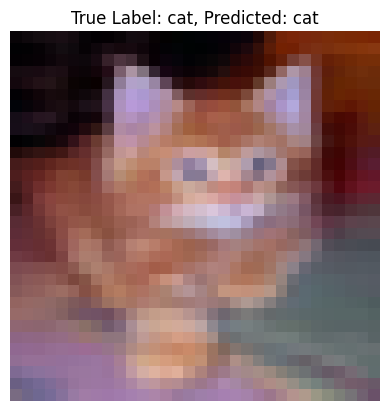

In [20]:
# Get the random image and its label
random_index = random.randint(0, len(dataset) - 1)
image, label = dataset[random_index]

# Get image embedding
image_features = get_image_embedding(image)

# Calculate cosine similarity between the image embedding and the text embeddings
similarities = (100.0 * image_features @ text_features.T).softmax(dim=-1)
predicted_class = similarities.argmax(dim=-1)

# Print the predicted class and the true label
print(f"Random Index: {random_index}")
print(f"Predicted class: {dataset.classes[predicted_class.item()]}")
print(f"True label: {dataset.classes[label]}")

# Display the randomly selected image
plt.imshow(image)
plt.title(f"True Label: {dataset.classes[label]}, Predicted: {dataset.classes[predicted_class.item()]}")
plt.axis("off")  # Turn off axis labels
plt.show()

### 2. Generating Concept Dictionary Using FLICKR-30k

Step 1: Loading Flickr-30k

In [21]:
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.4 MB/s eta 0:00:00


In [22]:
from datasets import load_dataset

# Load Flickr-30k Dataset
ds = load_dataset("lmms-lab/flickr30k")

README.md:   0%|          | 0.00/2.23k [00:00<?, ?B/s]

test-00000-of-00009.parquet:   0%|          | 0.00/471M [00:00<?, ?B/s]

test-00001-of-00009.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

test-00002-of-00009.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

test-00003-of-00009.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

test-00004-of-00009.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

test-00005-of-00009.parquet:   0%|          | 0.00/500M [00:00<?, ?B/s]

test-00006-of-00009.parquet:   0%|          | 0.00/528M [00:00<?, ?B/s]

test-00007-of-00009.parquet:   0%|          | 0.00/511M [00:00<?, ?B/s]

test-00008-of-00009.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/31783 [00:00<?, ? examples/s]

Extract Top 100 Concepts From Flickr-30k

In [23]:
import re

# Function to extract single-word concepts from captions
def extract_concepts(captions, max_concepts=100):
    words = []
    for caption in captions:
        # Remove non-alphabetic characters and split into words
        words += re.findall(r'\b\w+\b', caption.lower())

    # Filter out non-unique words and limit to max_concepts
    unique_words = list(set(words))
    return unique_words[:max_concepts]  # Limiting to most frequent concepts

# Flatten all captions into a single list of strings
captions = [caption for item in ds['test'] for caption in item['caption']]  # Flattening all captions

# Extract concepts (common words) from captions
concepts = extract_concepts(captions)

# Generate concept embeddings using CLIP's text encoder
text_inputs = processor(text=concepts, return_tensors="pt", padding=True).to(device)

with torch.no_grad():
    concept_embeddings = model.get_text_features(**text_inputs)
    concept_embeddings /= concept_embeddings.norm(dim=-1, keepdim=True)  # Normalize embeddings

# The matrix A, where each column is a concept embedding
A = concept_embeddings.T  # Transpose to match A in the form of Rdxc

# Output the shape of the concept matrix
print(f"Shape of the concept dictionary A: {A.shape}")
print(f"Sample concepts: {concepts[:10]}")

Shape of the concept dictionary A: torch.Size([768, 100])
Sample concepts: ['snow', 'dolls', 'cravat', 'culottes', 'stationary', '41', 'condemned', 'humans', 'polishing', 'rebuilding']


### 3. Aligning Image and Text Embeddings

In [24]:
import torch.nn.functional as F

# Get a random image from the Flickr-30k dataset
random_index = random.randint(0, len(ds['test']) - 1)
random_image = ds['test'][random_index]['image']  # Get the random image from the dataset

# Generate image embeddings for the selected image
image_embedding = get_image_embedding(random_image)

# Step 2: Compute the mean of the image embeddings and the concept dictionary embeddings
# Mean of image embeddings
image_mean = image_embedding.mean(dim=0, keepdim=True)

# Mean of concept dictionary (from Task 2 Step 2)
concept_mean = A.mean(dim=1, keepdim=True)

# Step 3: Center the embeddings
centered_image_embedding = image_embedding - image_mean
centered_concept_embeddings = A - concept_mean

# Step 4: Normalize the embeddings
normalized_image_embedding = F.normalize(centered_image_embedding, dim=-1)
normalized_concept_embeddings = F.normalize(centered_concept_embeddings, dim=-1)

# Output shapes to confirm alignment
print(f"Shape of normalized image embedding: {normalized_image_embedding.shape}")
print(f"Shape of normalized concept embeddings: {normalized_concept_embeddings.shape}")
print(f"Random Image Index: {random_index}")

Shape of normalized image embedding: torch.Size([1, 768])
Shape of normalized concept embeddings: torch.Size([768, 100])
Random Image Index: 8060


### 4. Solving The Optimisation Problem

In [25]:
from sklearn.linear_model import Lasso

# Step 1: Solve the optimization problem to get the sparse weight vector w

# Convert tensors to numpy arrays for use with sklearn
centered_image_embedding_np = centered_image_embedding.cpu().numpy()
centered_concept_embeddings_np = centered_concept_embeddings.cpu().numpy()

# Set regularization parameter lambda
lambda_val = 0.0025  # You can tune this parameter

# Lasso regression to solve for w (L1 regularization)
lasso = Lasso(alpha=lambda_val)
lasso.fit(centered_concept_embeddings_np, centered_image_embedding_np.squeeze())  # Solve for w
w = torch.tensor(lasso.coef_).to(device)  # Convert w back to a tensor

# Step 2: Reconstruct the sparse representation of the image embedding
sparse_image_embedding = torch.matmul(A, w.unsqueeze(1)) + concept_mean

# Output the shapes and a sample of the sparse vector
print(f"Shape of sparse image embedding: {sparse_image_embedding.shape}")
print(f"Sparse image embedding (first 10 values): {sparse_image_embedding[:10]}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Shape of sparse image embedding: torch.Size([768, 1])
Sparse image embedding (first 10 values): tensor([[ 0.0062],
        [ 0.0046],
        [ 0.0155],
        [-0.0111],
        [ 0.0018],
        [ 0.0093],
        [ 0.0121],
        [-0.0011],
        [ 0.0084],
        [ 0.0029]], device='cuda:0')


### 5. Zero-Shot Classification on a random image using both dense and sparse embeddings

True Caption: A beige dog runs through the tall grass with a tree in the background .


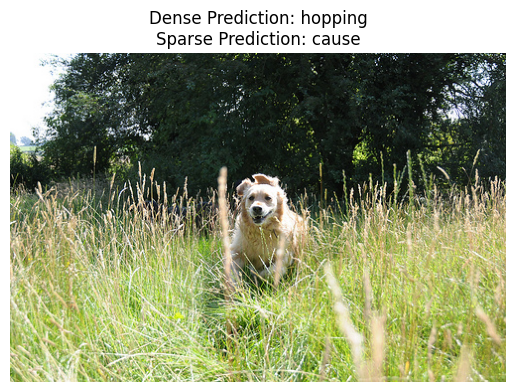

In [26]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Step 1: Compute cosine similarity for dense embeddings
dense_similarity = F.cosine_similarity(image_embedding, A.T, dim=-1)

# Step 2: Ensure proper dimensions for sparse embeddings before cosine similarity
sparse_image_embedding = sparse_image_embedding.squeeze(1)  # Remove the extra dimension
sparse_similarity = F.cosine_similarity(sparse_image_embedding.unsqueeze(0), A.T, dim=-1)

# Step 3: Get the predicted class for dense embeddings
dense_predicted_class_idx = dense_similarity.argmax().item()
dense_predicted_class = concepts[dense_predicted_class_idx]

# Step 4: Get the predicted class for sparse embeddings
sparse_predicted_class_idx = sparse_similarity.argmax().item()
sparse_predicted_class = concepts[sparse_predicted_class_idx]

# Step 5: Get the true label of the image
true_caption = ds['test'][random_index]['caption'][0]  # First caption of the randomly selected image

# Step 6: Display the image
print(f"True Caption: {true_caption}")
plt.imshow(random_image)
plt.title(f"Dense Prediction: {dense_predicted_class}\nSparse Prediction: {sparse_predicted_class}")
plt.axis("off")
plt.show()


### 6. Comparing Dense vs Sparse Accuracy for CIFAR-10
Step 1: Loading in the model and dataset

In [27]:
import torch
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
from scipy.sparse import csr_matrix
import sys

# Load the CLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

# Load CIFAR-10 dataset
cifar10 = load_dataset("cifar10")

# Define CIFAR-10 classes
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [28]:
# Process CIFAR-10 images and labels
def preprocess_images(dataset, max_images=None):
    images = []
    labels = []
    for i, example in enumerate(dataset):
        if max_images and i >= max_images:
            break
        img = example['img']
        images.append(img)
        labels.append(example['label'])
    return images, labels

# Preprocess Images
images, true_labels = preprocess_images(cifar10['test'], max_images=None)

## Generating Image Embeddings of Entire Dataset

Split the dataset into smaller batches to manage memory constraints and compute image embeddings using CLIP.

After processing all batches, the embeddings are concatenated into one matrix. The next step involves calculating the mean embedding across all images to center the data by subtracting this mean from each embedding, which shifts the data to be zero-centered.

Finally, the centered embeddings are normalized by scaling each to have unit magnitude, ensuring they are on the same scale for better comparison.

During centering, the mean embedding is computed along axis 0, meaning the average is taken across all images for each feature (or embedding dimension). This results in a mean vector that is subtracted from each image embedding feature-wise, aligning the data to be zero-centered along each feature.

For normalization, the L2 norm is computed along axis 1, which means the norm is calculated across all features of each image embedding individually (row-wise). Each embedding is then divided by its norm, normalizing each embedding to have a unit length while preserving the relationships between images in the embedding space.

In [29]:
# Process the dataset in batches and obtain dense image embeddings
def process_in_batches(batch_size, images, model, processor, device):
    z_img_dense_list = []
    for i in range(0, len(images), batch_size):
        batch_images = images[i:i + batch_size]
        inputs = processor(images=batch_images, return_tensors="pt", padding=True).to(device)

        # Compute dense image embeddings in batches
        with torch.no_grad():
            z_img_dense = model.get_image_features(**inputs)
        z_img_dense_list.append(z_img_dense.cpu().numpy())

    # Concatenate all batches
    z_img_dense = np.concatenate(z_img_dense_list, axis=0)

    # Step 1: Compute the mean of the dense image embeddings
    image_mean = np.mean(z_img_dense, axis=0, keepdims=True)

    # Step 2: Center the image embeddings
    centered_image_embeddings = z_img_dense - image_mean

    # Step 3: Normalize the centered embeddings
    z_img_dense_normalized = centered_image_embeddings / np.linalg.norm(centered_image_embeddings, axis=1, keepdims=True)

    return z_img_dense_normalized

# Generate dense and centered-normalized image embeddings
batch_size = 100  # Adjust batch size according to your GPU memory
z_img_dense_normalized = process_in_batches(batch_size, images, model, processor, device)
print(f"Image Embeddings Shape: {z_img_dense_normalized.shape}")

Image Embeddings Shape: (10000, 768)


## Creating CIFAR-10 Concept Dictionary

### Class Embedding Generation:

The function get_class_embeddings_with_centering first processes the input class labels (text) using the CLIP processor. It converts these text labels into tensors suitable for the model.

The model then generates text embeddings for each class label. These embeddings are numerical representations of the class names in a high-dimensional space.

The mean embedding is calculated along axis 1, which means the average is computed across the features for each class individually. This produces a mean value for each class's embedding across its features.

The embeddings are then centered by subtracting the mean from each embedding. Since the mean is computed along axis 1 (feature-wise for each class), this subtraction centers each class embedding around its own mean, making the embeddings zero-centered.

The normalization step computes the L2 norm along axis 0, meaning the norm is calculated across all class embeddings for each feature (column-wise normalization). This normalizes each feature across all classes so that the magnitude of each feature becomes 1.

By normalizing along axis 0, each feature across all class embeddings is scaled uniformly, preserving the relative differences between classes.

In [30]:
# Create a concept dictionary using CIFAR-10 class names
def get_class_embeddings_with_centering(class_labels, model, processor, device):
    inputs = processor(text=class_labels, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        class_embeddings = model.get_text_features(**inputs)
    class_embeddings = class_embeddings.cpu().numpy()

    # Step 1: Compute the mean of the concept dictionary embeddings
    concept_mean = np.mean(class_embeddings, axis=1, keepdims=True)

    # Step 2: Center the concept dictionary embeddings
    centered_concept_embeddings = class_embeddings - concept_mean

    # Step 3: Normalize the centered embeddings
    centered_normalized_concept_embeddings = centered_concept_embeddings / np.linalg.norm(centered_concept_embeddings, axis=0, keepdims=True)

    return centered_normalized_concept_embeddings

# Generate centered-normalized concept dictionary embeddings
A_centered_normalized = get_class_embeddings_with_centering(cifar10_classes, model, processor, device)
print(f"Concept Dictionary Shape: {A_centered_normalized.T.shape}")

Concept Dictionary Shape: (768, 10)


Functions to Induce Sparsity by solving the optimisation problem.

In [31]:
# Function to store sparse embeddings using a sparse weight matrix format
def lasso_sparse_reconstruction(z_img_dense_normalized, A_centered_normalized, alpha):
    lasso = Lasso(alpha=alpha, fit_intercept=False)
    sparse_reconstructed_images = []

    for dense_embedding in z_img_dense_normalized:
        lasso.fit(A_centered_normalized.T, dense_embedding)  # Fit Lasso
        w_sparse = lasso.coef_  # Sparse weight vector (size: 10)

        # Reconstruct sparse embedding in 768-dimensional space
        sparse_image = A_centered_normalized.T @ w_sparse  # This should give a (768,) embedding

        # Convert the result to sparse matrix format for efficiency
        sparse_matrix = csr_matrix(sparse_image)  # Convert to sparse matrix format
        sparse_reconstructed_images.append(sparse_matrix)

    return sparse_reconstructed_images  # Return list of sparse matrices

def normalize_sparse_images(sparse_images):
    normalized_images = []
    for sparse_image in sparse_images:
        dense_image = sparse_image.toarray().flatten()  # Convert to dense for normalization
        norm = np.linalg.norm(dense_image) + 1e-8  # Prevent division by zero
        normalized_dense = dense_image / norm  # Normalize the dense image
        sparse_normalized = csr_matrix(normalized_dense)  # Convert back to sparse matrix format
        normalized_images.append(sparse_normalized)
    return normalized_images

# Convert normalized sparse embeddings to dense for cosine similarity
def sparse_to_dense(sparse_matrices):
    return np.array([sparse_matrix.toarray().flatten() for sparse_matrix in sparse_matrices])

# Sparsity
sparse_reconstructed_images = lasso_sparse_reconstruction(z_img_dense_normalized, A_centered_normalized, alpha=0.0055)

# Normalize the sparse embeddings
sparse_reconstructed_images_normalized = normalize_sparse_images(sparse_reconstructed_images)

sparse_reconstructed_images_dense = sparse_to_dense(sparse_reconstructed_images_normalized)

print(f"Number of Sparse Images: {len(sparse_reconstructed_images)}")
print(f"Shape of One Sparse Image: {sparse_reconstructed_images[0].shape}")

Number of Sparse Images: 10000
Shape of One Sparse Image: (1, 768)


Dense vs Sparse Accuracy For Sparse Alpha = 0.0055

In [32]:
# Compute cosine similarity for dense embeddings
dense_cosine_similarities = cosine_similarity(z_img_dense_normalized, A_centered_normalized)
dense_predictions = np.argmax(dense_cosine_similarities, axis=1)
dense_accuracy = accuracy_score(true_labels, dense_predictions)

# Compute cosine similarity for sparse embeddings (images to class embeddings)
sparse_cosine_similarities = cosine_similarity(sparse_reconstructed_images_dense, A_centered_normalized)
sparse_predictions = np.argmax(sparse_cosine_similarities, axis=1)
sparse_accuracy = accuracy_score(true_labels, sparse_predictions)

print(f"Accuracy of Zero-Shot Classification (Dense Embeddings): {dense_accuracy * 100:.2f}%")
print(f"Accuracy of Zero-Shot Classification (Sparse Embeddings): {sparse_accuracy * 100:.2f}%")

Accuracy of Zero-Shot Classification (Dense Embeddings): 94.76%
Accuracy of Zero-Shot Classification (Sparse Embeddings): 10.00%


Calculating and Displaying Memory Footprint and Sparsity Level

In [33]:
# Memory
def memory_footprint(embeddings):
    return sys.getsizeof(embeddings) / (1024 * 1024)  # Convert to MB

# Memory footprint for sparse matrices
def sparse_memory_footprint(sparse_matrices):
    total_memory = 0
    for sparse_matrix in sparse_matrices:
        if isinstance(sparse_matrix, csr_matrix):
            total_memory += sparse_matrix.data.nbytes  # Memory used by sparse data
    return total_memory / (1024 * 1024)  # Convert to MB

def calculate_sparsity(sparse_matrices):
    total_elements = 0
    non_zero_elements = 0

    for sparse_matrix in sparse_matrices:
        if isinstance(sparse_matrix, csr_matrix):
            total_elements += sparse_matrix.shape[0] * sparse_matrix.shape[1]
            non_zero_elements += sparse_matrix.nnz  # Number of non-zero elements in the sparse matrix

    sparsity = 100 * (1 - non_zero_elements / total_elements)
    return sparsity

dense_memory = memory_footprint(z_img_dense_normalized)
sparse_memory = sparse_memory_footprint(sparse_reconstructed_images)
sparse_sparsity = calculate_sparsity(sparse_reconstructed_images)

print(f"Memory footprint of dense embeddings: {dense_memory:.2f} MB")
print(f"Memory footprint of sparse embeddings: {sparse_memory:.2f} MB")
print(f"Sparsity in sparse embeddings: {sparse_sparsity:.2f}%")

Memory footprint of dense embeddings: 29.30 MB
Memory footprint of sparse embeddings: 0.00 MB
Sparsity in sparse embeddings: 100.00%


Visualising Sparsity Level vs Zero-Shot Accuracy for different alpha values

In [34]:
# Function to get the top contributing classes
def get_top_contributing_classes(sparse_embedding, class_embeddings, classes, top_n=5):
    # Convert the sparse embedding to a dense array
    sparse_embedding_dense = sparse_embedding.toarray().flatten()  # Convert to dense

    # Normalize the sparse embedding (just in case it's not normalized)
    sparse_embedding_normalized = sparse_embedding_dense / (np.linalg.norm(sparse_embedding_dense) + 1e-8)

    # Compute cosine similarity between sparse embedding and class embeddings
    similarities = cosine_similarity(sparse_embedding_normalized.reshape(1, -1), class_embeddings).flatten()

    # Get indices of top contributing classes (sorted by similarity)
    top_class_indices = np.argsort(-similarities)[:top_n]
    top_classes = [(classes[i], similarities[i]) for i in top_class_indices]
    return top_classes

In [35]:
import matplotlib.pyplot as plt

# Example alpha values to test sparsity and accuracy
#alpha_values = [0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005]

alpha_values = np.linspace(0.0005, 0.005, 20)

# Initialize lists to collect sparsity and accuracy data
sparsity_levels = []
accuracy_sparse = []
sparse_memories = []
all_top_classes_per_alpha = []
similarity_matrices = []

for alpha in alpha_values:
    print(f"Testing with alpha = {alpha}")

    # Step 1: Lasso to generate sparse embeddings
    sparse_reconstructed_images = lasso_sparse_reconstruction(z_img_dense_normalized, A_centered_normalized, alpha=alpha)

    # Normalize the sparse embeddings
    sparse_reconstructed_images_normalized = normalize_sparse_images(sparse_reconstructed_images)

    # Convert normalized sparse embeddings to dense for cosine similarity
    def sparse_to_dense(sparse_matrices):
        return np.array([sparse_matrix.toarray().flatten() for sparse_matrix in sparse_matrices])

    sparse_reconstructed_images_dense = sparse_to_dense(sparse_reconstructed_images_normalized)

    # Compute cosine similarity for sparse embeddings (images to class embeddings)
    sparse_cosine_similarities = cosine_similarity(sparse_reconstructed_images_dense, A_centered_normalized)
    sparse_predictions = np.argmax(sparse_cosine_similarities, axis=1)
    sparse_accuracy = accuracy_score(true_labels, sparse_predictions)

    # Calculate memory footprint and sparsity
    sparse_memory = sparse_memory_footprint(sparse_reconstructed_images)
    sparse_sparsity = calculate_sparsity(sparse_reconstructed_images)

    # Print results
    print(f"Accuracy of Zero-Shot Classification (Sparse Embeddings): {sparse_accuracy * 100:.2f}%")
    print(f"Memory footprint of sparse embeddings: {sparse_memory:.2f} MB")
    print(f"Sparsity in sparse embeddings: {sparse_sparsity:.2f}%")
    print()

    # Collect sparsity and accuracy data for plotting
    sparsity_levels.append(sparse_sparsity)
    accuracy_sparse.append(sparse_accuracy * 100)
    sparse_memories.append(sparse_memory)

    # Store the similarity matrix for this alpha value
    similarity_matrices.append(sparse_cosine_similarities)

    # Collect top contributing classes for each image
    top_classes_for_this_alpha = []
    for idx in range(len(sparse_reconstructed_images)):
        sparse_embedding = sparse_reconstructed_images[idx]

        # Get top contributing classes for this image
        top_classes = get_top_contributing_classes(sparse_embedding, A_centered_normalized, cifar10_classes, top_n=5)
        top_classes_for_this_alpha.append(top_classes)

    all_top_classes_per_alpha.append(top_classes_for_this_alpha)

Testing with alpha = 0.0005
Accuracy of Zero-Shot Classification (Sparse Embeddings): 94.65%
Memory footprint of sparse embeddings: 29.29 MB
Sparsity in sparse embeddings: 0.04%

Testing with alpha = 0.0007368421052631579
Accuracy of Zero-Shot Classification (Sparse Embeddings): 94.05%
Memory footprint of sparse embeddings: 29.19 MB
Sparsity in sparse embeddings: 0.35%

Testing with alpha = 0.0009736842105263158
Accuracy of Zero-Shot Classification (Sparse Embeddings): 92.19%
Memory footprint of sparse embeddings: 28.76 MB
Sparsity in sparse embeddings: 1.83%

Testing with alpha = 0.0012105263157894737
Accuracy of Zero-Shot Classification (Sparse Embeddings): 88.77%
Memory footprint of sparse embeddings: 27.58 MB
Sparsity in sparse embeddings: 5.85%

Testing with alpha = 0.0014473684210526317
Accuracy of Zero-Shot Classification (Sparse Embeddings): 83.08%
Memory footprint of sparse embeddings: 25.17 MB
Sparsity in sparse embeddings: 14.07%

Testing with alpha = 0.0016842105263157896
A

### Visualising Our Testing

Top Row:

Alpha vs. Sparsity

Alpha vs. Accuracy

Alpha vs. Memory Footprint

Bottom Row:

Sparsity vs. Accuracy

Sparsity vs. Memory Footprint

Accuracy vs. Memory Footprint

This layout provides a comprehensive view of how alpha, sparsity, accuracy, and memory footprint are related.

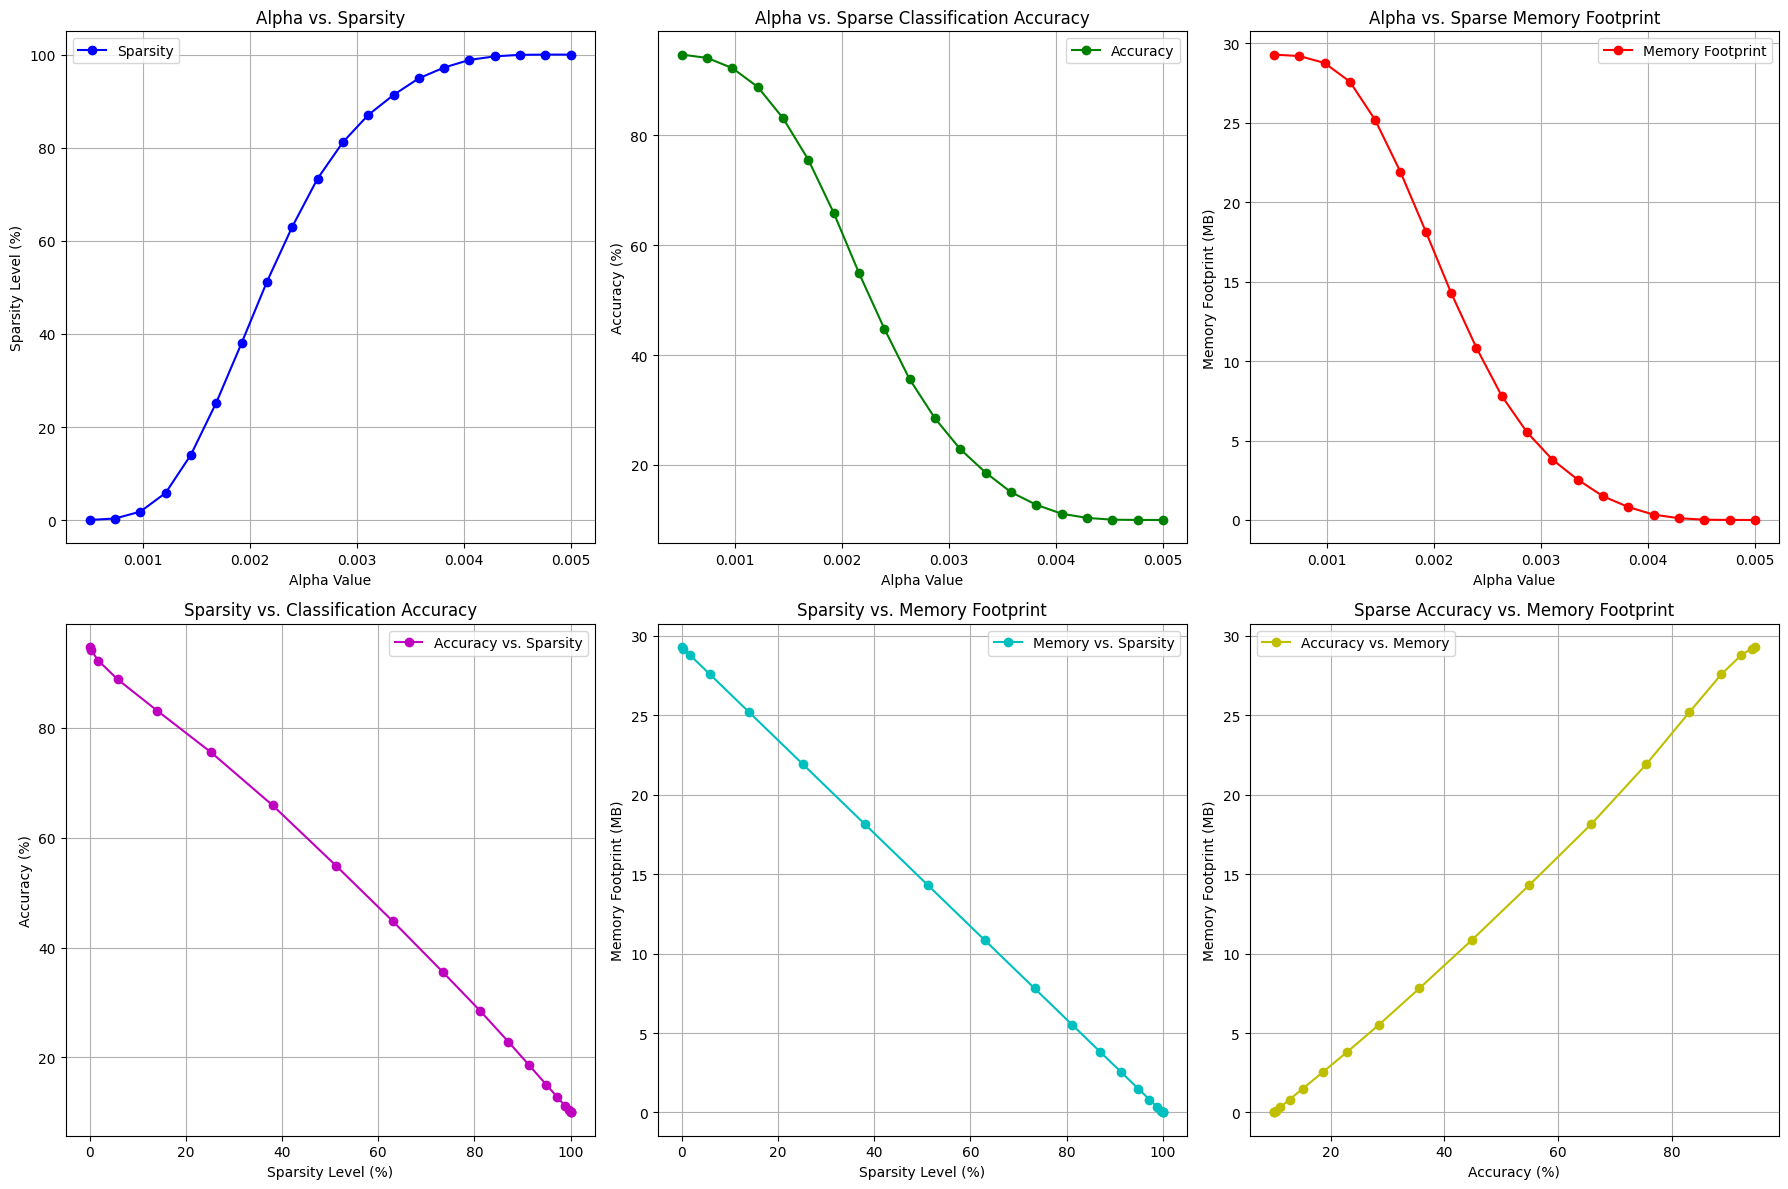

╒═════════╤══════════════════════╤════════════════╤═════════════════════════╕
│   Alpha │   Sparsity Level (%) │   Accuracy (%) │   Memory Footprint (MB) │
╞═════════╪══════════════════════╪════════════════╪═════════════════════════╡
│  0.0005 │                 0.04 │          94.65 │                   29.29 │
├─────────┼──────────────────────┼────────────────┼─────────────────────────┤
│  0.0007 │                 0.35 │          94.05 │                   29.19 │
├─────────┼──────────────────────┼────────────────┼─────────────────────────┤
│  0.001  │                 1.83 │          92.19 │                   28.76 │
├─────────┼──────────────────────┼────────────────┼─────────────────────────┤
│  0.0012 │                 5.85 │          88.77 │                   27.58 │
├─────────┼──────────────────────┼────────────────┼─────────────────────────┤
│  0.0014 │                14.07 │          83.08 │                   25.17 │
├─────────┼──────────────────────┼────────────────┼─────────────

In [36]:
import matplotlib.pyplot as plt
from tabulate import tabulate
import numpy as np

# Create a figure with 2 rows and 3 columns of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Subplot 1: Alpha vs. Sparsity
axes[0, 0].plot(alpha_values, sparsity_levels, marker='o', linestyle='-', color='b', label='Sparsity')
axes[0, 0].set_title("Alpha vs. Sparsity")
axes[0, 0].set_xlabel("Alpha Value")
axes[0, 0].set_ylabel("Sparsity Level (%)")
axes[0, 0].grid(True)
axes[0, 0].legend()

# Subplot 2: Alpha vs. Accuracy
axes[0, 1].plot(alpha_values, accuracy_sparse, marker='o', linestyle='-', color='g', label='Accuracy')
axes[0, 1].set_title("Alpha vs. Sparse Classification Accuracy")
axes[0, 1].set_xlabel("Alpha Value")
axes[0, 1].set_ylabel("Accuracy (%)")
axes[0, 1].grid(True)
axes[0, 1].legend()

# Subplot 3: Alpha vs. Memory Footprint
axes[0, 2].plot(alpha_values, sparse_memories, marker='o', linestyle='-', color='r', label='Memory Footprint')
axes[0, 2].set_title("Alpha vs. Sparse Memory Footprint")
axes[0, 2].set_xlabel("Alpha Value")
axes[0, 2].set_ylabel("Memory Footprint (MB)")
axes[0, 2].grid(True)
axes[0, 2].legend()

# Subplot 4: Sparsity vs. Accuracy
axes[1, 0].plot(sparsity_levels, accuracy_sparse, marker='o', linestyle='-', color='m', label='Accuracy vs. Sparsity')
axes[1, 0].set_title("Sparsity vs. Classification Accuracy")
axes[1, 0].set_xlabel("Sparsity Level (%)")
axes[1, 0].set_ylabel("Accuracy (%)")
axes[1, 0].grid(True)
axes[1, 0].legend()

# Subplot 5: Sparsity vs. Memory Footprint
axes[1, 1].plot(sparsity_levels, sparse_memories, marker='o', linestyle='-', color='c', label='Memory vs. Sparsity')
axes[1, 1].set_title("Sparsity vs. Memory Footprint")
axes[1, 1].set_xlabel("Sparsity Level (%)")
axes[1, 1].set_ylabel("Memory Footprint (MB)")
axes[1, 1].grid(True)
axes[1, 1].legend()

# Subplot 6: Accuracy vs. Memory Footprint
axes[1, 2].plot(accuracy_sparse, sparse_memories, marker='o', linestyle='-', color='y', label='Accuracy vs. Memory')
axes[1, 2].set_title("Sparse Accuracy vs. Memory Footprint")
axes[1, 2].set_xlabel("Accuracy (%)")
axes[1, 2].set_ylabel("Memory Footprint (MB)")
axes[1, 2].grid(True)
axes[1, 2].legend()

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()

# Create the results table
results_table = [
    [f"{alpha:.4f}", f"{sparsity:.2f}", f"{accuracy:.2f}", f"{memory:.2f}"]
    for alpha, sparsity, accuracy, memory in zip(alpha_values, sparsity_levels, accuracy_sparse, sparse_memories)
]

# Define headers
headers = ["Alpha", "Sparsity Level (%)", "Accuracy (%)", "Memory Footprint (MB)"]

# Print the table using tabulate
print(tabulate(results_table, headers=headers, tablefmt="fancy_grid"))

## Visualising top contributing concepts using random exmaples from CIFAR-10

### Why are non-related classes contributing so much?

The dictionary
𝐴
 is trained to capture generic features that are relevant across multiple classes. Many visual patterns (edges, textures, shapes) are shared among classes, which explains why unrelated classes can still have high similarity scores.
For example, "bird" and "horse" may share features related to the general shape of the body or textures that the model finds useful in distinguishing these animals, even though the images belong to different classes. Similarly, "frog" might contribute due to texture similarities (smooth, natural surfaces) with the "bird" class.
The lasso reconstruction algorithm aims for a sparse representation, meaning that it selects only a few atoms (concepts) to represent the image. If these atoms are shared across multiple classes, this leads to high similarity for those classes even if they are not the true label.

### Confusion due to shared visual features:

Classes like "horse," "frog," and "deer" all belong to the animal category, where certain visual traits like organic shapes, fur-like textures, or background similarities can overlap. This can cause confusion in sparse embeddings when a "bird" image is being reconstructed, as it may activate visual patterns similar to those found in other animal classes.
The "ship" class might seem out of place, but it’s possible that parts of the image (e.g., background patterns, structural edges) are similar to the hull or deck of a ship, leading to its inclusion in the top contributing classes.

First: Visualising Top Contributing Classes For Three Random Images


Image 7379:


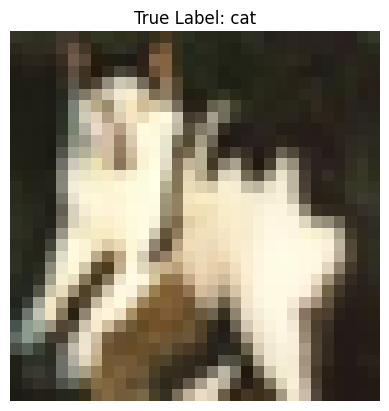

Top contributing classes:
Class: cat, Similarity: 1.0000
Class: dog, Similarity: 0.5984
Class: automobile, Similarity: 0.3226
Class: bird, Similarity: 0.2274
Class: deer, Similarity: 0.2079

Image 7144:


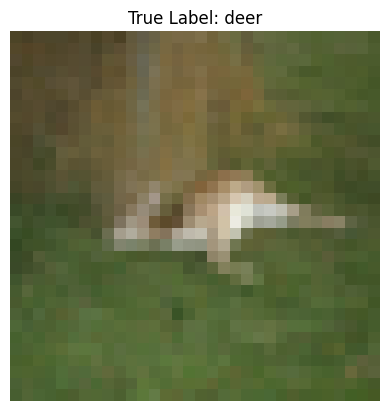

Top contributing classes:
Class: deer, Similarity: 0.9392
Class: horse, Similarity: 0.3183
Class: dog, Similarity: 0.2250
Class: bird, Similarity: 0.2086
Class: frog, Similarity: 0.1879

Image 6781:


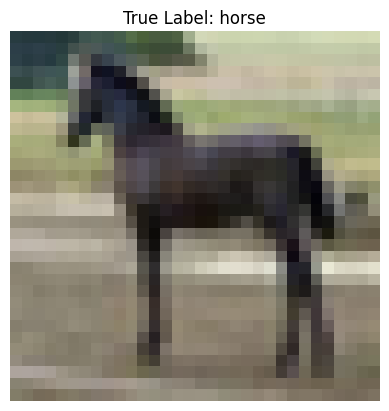

Top contributing classes:
Class: horse, Similarity: 0.9886
Class: deer, Similarity: 0.3971
Class: bird, Similarity: 0.2828
Class: dog, Similarity: 0.2495
Class: frog, Similarity: 0.2042


In [37]:
import random

# Function to display image and its top contributing classes, along with the true label
def show_image_with_top_classes(image, top_classes, true_label):
    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"True Label: {true_label}")
    plt.show()

    # Print the top contributing classes and their similarity scores
    print("Top contributing classes:")
    for class_name, similarity in top_classes:
        print(f"Class: {class_name}, Similarity: {similarity:.4f}")

# List of CIFAR-10 classes
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# SParsity
alpha_value = 0.001
sparse_reconstructed_images = lasso_sparse_reconstruction(z_img_dense_normalized, A_centered_normalized, alpha=alpha_value)

# Select three random indices from the dataset
random_indices = random.sample(range(len(images)), 3)

# Analyze three random images from the dataset
for idx in random_indices:
    image = images[idx]  # Get the original image
    sparse_embedding = sparse_reconstructed_images[idx]  # Sparse embedding for this image
    true_label = cifar10_classes[true_labels[idx]]  # Get the true label

    # Get the top 5 contributing CIFAR-10 classes for this image
    top_classes = get_top_contributing_classes(sparse_embedding, A_centered_normalized, cifar10_classes, top_n=5)

    # Display the image, its true label, and its top contributing classes
    print(f"\nImage {idx + 1}:")
    show_image_with_top_classes(image, top_classes, true_label)

### Visualising Top Contributing Classes For The Entire Cifar-10 Dataset For 10 different Alpha Values

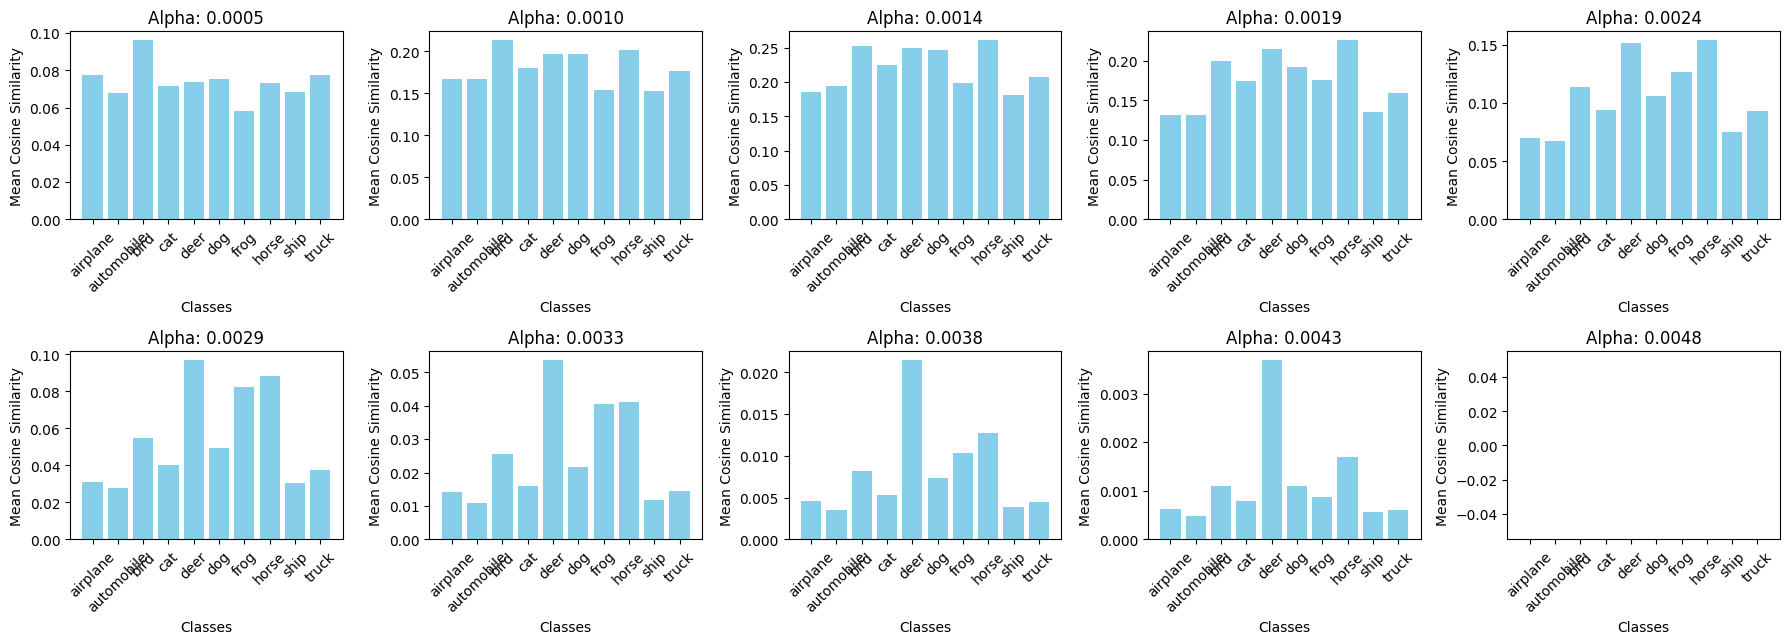

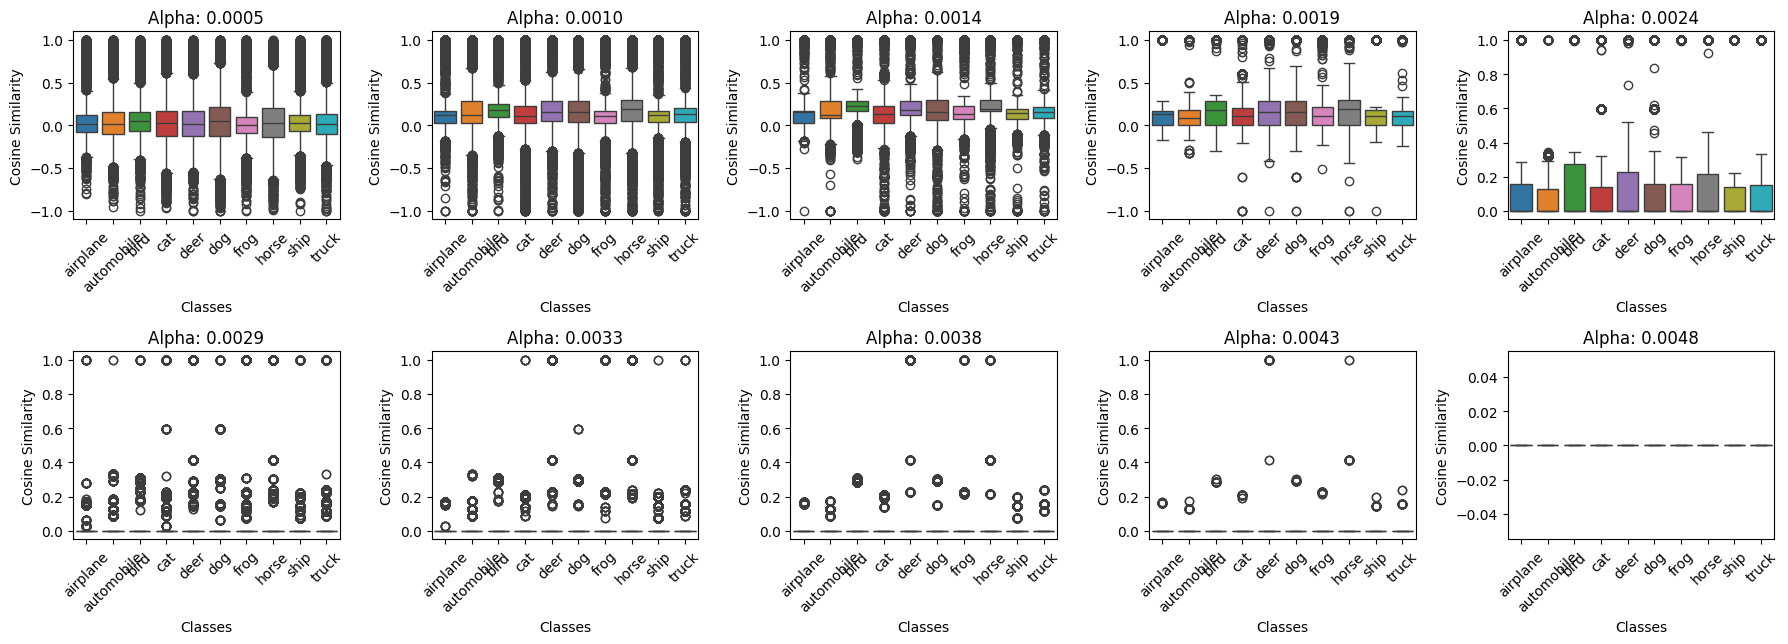

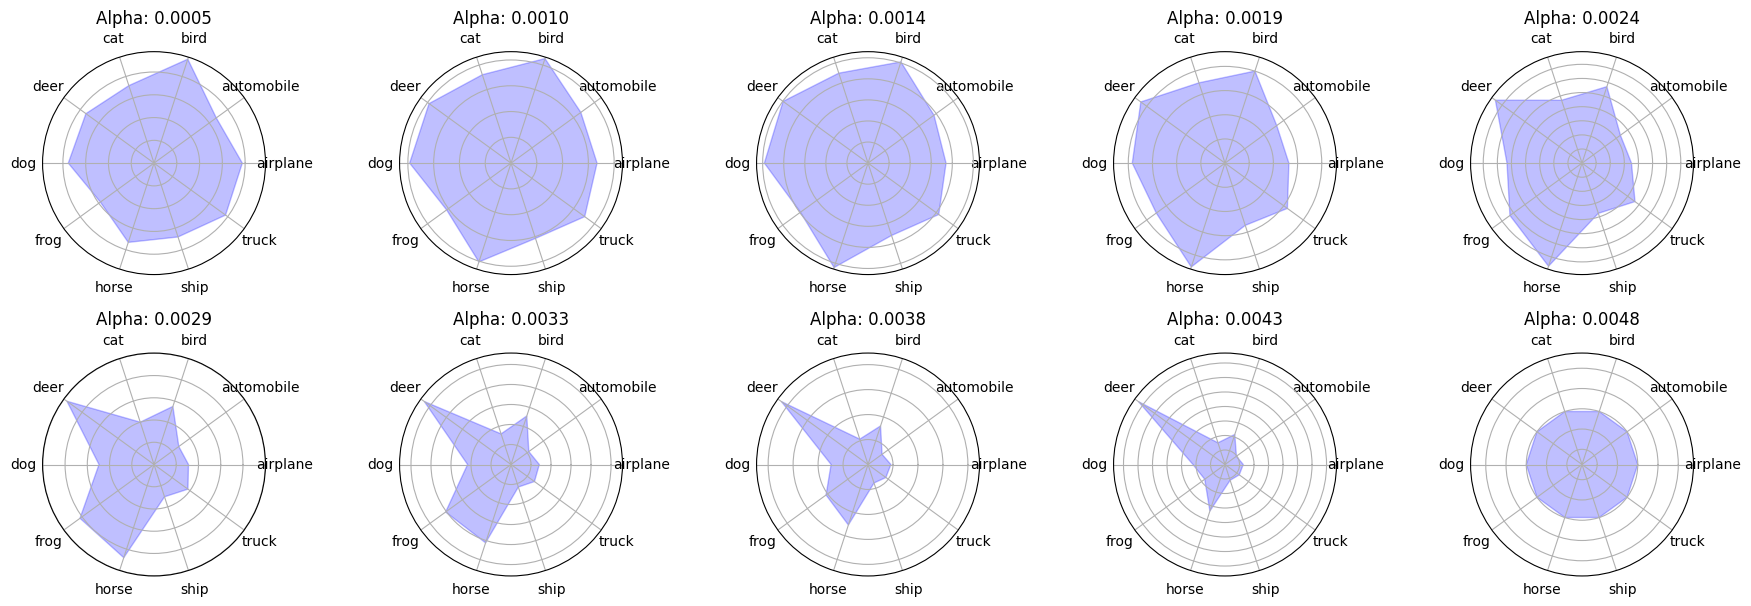

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Assuming the following data has been collected from the previous loop
# sparsity_levels, accuracy_sparse, sparse_memories, similarity_matrices, all_top_classes_per_alpha

# Number of alphas
num_alphas = len(alpha_values)

# Select every second alpha value for visualization
selected_indices = np.arange(0, num_alphas, 2)  # [0, 2, 4, ...]
selected_alpha_values = alpha_values[selected_indices]
selected_similarity_matrices = [similarity_matrices[i] for i in selected_indices]

# Bar charts for similarity scores across classes for each selected alpha value
plt.figure(figsize=(18, 12))

for i, idx in enumerate(selected_indices):
    plt.subplot(4, 5, i + 1)  # Create a subplot for each selected alpha
    mean_similarity = np.mean(selected_similarity_matrices[i], axis=0)  # Mean similarity per class
    plt.bar(cifar10_classes, mean_similarity, color='skyblue')
    plt.title(f'Alpha: {selected_alpha_values[i]:.4f}')
    plt.xlabel('Classes')
    plt.ylabel('Mean Cosine Similarity')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Box plots for similarity scores across classes for each selected alpha
plt.figure(figsize=(18, 12))

for i, idx in enumerate(selected_indices):
    plt.subplot(4, 5, i + 1)
    sns.boxplot(data=selected_similarity_matrices[i])
    plt.title(f'Alpha: {selected_alpha_values[i]:.4f}')
    plt.xlabel('Classes')
    plt.ylabel('Cosine Similarity')
    plt.xticks(ticks=np.arange(len(cifar10_classes)), labels=cifar10_classes, rotation=45)

plt.tight_layout()
plt.show()

# Set up the figure for radar charts
def plot_radar_chart(data, classes, title):
    num_vars = len(classes)

    # Compute angle for each class
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Complete the loop
    data = np.concatenate((data, [data[0]]))
    angles += angles[:1]

    ax = plt.subplot(4, 5, i + 1, polar=True)  # Create subplot for radar chart
    ax.fill(angles, data, color='blue', alpha=0.25)
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(classes)
    ax.set_title(title)

# Create radar charts for each selected alpha value
plt.figure(figsize=(18, 12))
for i, idx in enumerate(selected_indices):
    avg_similarities = np.mean(selected_similarity_matrices[i], axis=0)  # Average similarity per class
    plot_radar_chart(avg_similarities, cifar10_classes, f'Alpha: {selected_alpha_values[i]:.4f}')

plt.tight_layout()
plt.show()

# Task 3: ISTA for Sparse Vector Recovery

## Section 1: Optimization

We first start by considering a well formulated problem:

Consider some noisy observations $\mathbf{x} \in \mathbb{R}^{m}$ generated from the following process:

$$
\begin{align}
\mathbf{x} = \mathbf{Az} + \mathbf{n}
\end{align}
$$

where $\mathbf{z} \in \mathbb{R}^{m}$ is our target signal, $\mathbf{A} \in \mathbb{R}^{m \times n}$ is a linear operator representing the process by which the signal has been measured, and $\mathbf{n} \in \mathbb{R}^{n}$ represents additive noise. Our objective is to recover $\mathbf{x}$.


This can be formulated as an optimization problem as follows:
$$
\begin{align}
\min_{\mathbf{z}} ||\mathbf{x} - \mathbf{Az}||_{2}^{2}
\end{align}
$$

This is the well known, least squares regression problem and there are various methods to solve it. We make our problem more interesting by adding the constraint that $\mathbf{x}$ is **sparse**. Noting that the $l_{0}$ norm measures sparsity, our new optimization problem is:

$$
\begin{align}
\min_{\mathbf{z}} ||\mathbf{x} - \mathbf{Az}||_{2}^{2} + \lambda||\mathbf{z}||_{0}
\end{align}
$$

This problem is **not** convex and hence cannot be solved using conventional gradient based methods.

We relax the $l_{0}$ norm to the $l_{1}$ norm in order to bring our problem in the domain of convex problems:

$$
\begin{align}
\min_{\mathbf{z}} ||\mathbf{x} - \mathbf{Az}||_{2}^{2} + \lambda||\mathbf{z}||_{1}
\end{align}
$$

You may know this as lasso regression. Note that this problem is not solvable via gradient descent since the $l_{1}$ norm is not differentiable. Many solvers exist for this problem, but we shall take a different approach known as the **Iterative Soft Thresholding Algorithm (ISTA)**.

We can write our optimization objective as a sum of two functions:

$$
\begin{align}
\min_{\mathbf{z}}{h(\mathbf{z}) = f(\mathbf{z}) + g(\mathbf{z})}
\end{align}
$$

where $f$ is convex and differentiable while $g$ is convex but not necessarily differentiable.

Note that if $g$ was differentiable, we could use a gradient based approach (e.g. gradient descent) to minimize it. Our approach is to design an iterative algorithm such that at iteration $k$ where the algorithm is at point $\mathbf{z}_k$, we minimize another convex function $m_{k}$ fulfilling the following conditions:

$$
\begin{align}
m_{k}(\mathbf{z}) &\geq h(\mathbf{z}) \; \; ∀ \mathbf{z} \\
m_{k}(\mathbf{z}_{k}) &= h(\mathbf{z}_{k})
\end{align}
$$

Our update equation then becomes:
$$
\begin{align}
\mathbf{z}_{k+1} = \min_{\mathbf{z}}{m_{k}({\mathbf{z}})}
\end{align}
$$

Coming back to our problem, we define the following function:
$$
\begin{align}
m_{k}(\mathbf{z}) = ||\mathbf{x} - \mathbf{Az}||_{2}^{2} + λ||\mathbf{z}||_{1} + (\mathbf{z} - \mathbf{z}_{k})^{T}(α\mathbf{I} - \mathbf{A}^{T}\mathbf{A})(\mathbf{x} - \mathbf{z}_{k})
\end{align}
$$

Note that at $\mathbf{z} = \mathbf{z}_{k}$, the additional quadratic term becomes 0 while for all other $\mathbf{z}$, the additional term is positive as long as $α > \max(\text{eig}(\mathbf{A}^{T}\mathbf{A}))$ thereby satisfying the two conditions defined above. Each iterative step that minimizes this function, also minimizes the original objective function.
The expression for $\min_{\mathbf{z}}m_{k}(\mathbf{z}_{k})$ can be written as follows:

$$
\begin{align}
\min_{\mathbf{z}}{||\mathbf{z}_{k} + \frac{1}{\alpha}\mathbf{A}^{T}(\mathbf{x} - \mathbf{A}\mathbf{z}_{k}) - \mathbf{z}||_{2}^{2} + \frac{λ}{\alpha}||\mathbf{z}||_{1}}
\end{align}
$$
While an exact solution for the miniimzation problem does not exist, by finding a minimizer at each $k$, we can approach the global minimizer of the original problem.

Each update iteration looks as follows:
$$
\begin{align}
\mathbf{z}_{k+1} = \text{soft}(\mathbf{z}_{k} + \frac{1}{\alpha}\mathbf{A}(\mathbf{x} - \mathbf{A}^{T}\mathbf{z}_{k}), \frac{\lambda}{2\alpha})
\end{align}
$$

Where:
$$
\begin{align}
\text{soft}(\mathbf{x}, \tau) := \text{sign}(\mathbf{x})\max(0, |\mathbf{x}| - \tau)
\end{align}
$$

The soft thresholding operator is also known as the proximal gradient operator for the $l_{1}$ norm.

Consider the following example where $\mathbf{z} \in \mathbb{R}^{100}$,  $\mathbf{A} \in \mathbb{R}^{100 \times 100}$ and $\mathbf{n} \sim \mathcal{N}(0, 0.05^{2}\mathbf{I}) \in \mathbb{R}^{100}$:

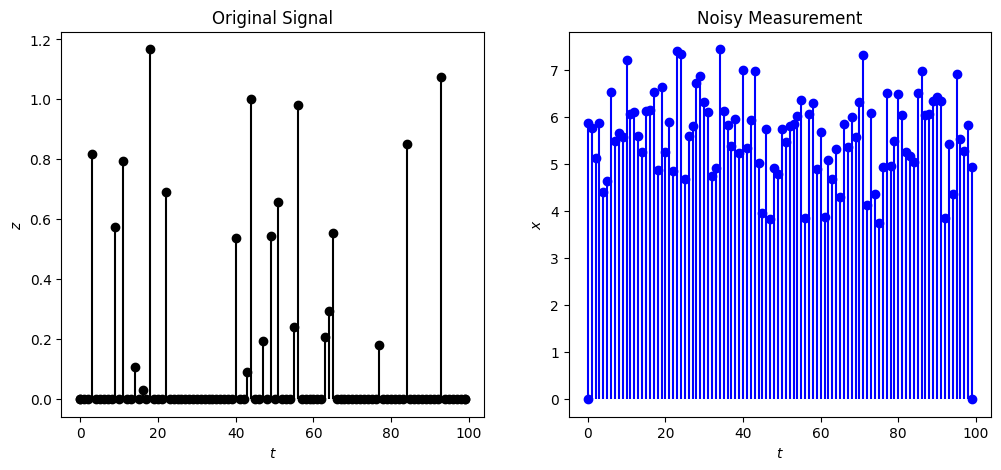

In [3]:
t = np.arange(0, 100, 1)
z = 1.5 * np.random.rand(len(t))
z = z * np.array([0 if np.random.rand() < 0.8 else 1 for i in range(len(t))])

A = np.random.rand(100, 100)

sigma = 0.05
noise = np.random.normal(0, sigma)
x = A @ z + noise


fig = plt.figure(1, dpi=100, figsize=(12, 5))
ax  = fig.subplots(nrows=1, ncols=2)
_   = ax[0].stem(t, z, "k", basefmt="ko")
_   = ax[0].set_xlabel(r'$t$')
_   = ax[0].set_ylabel(r'$z$')
_   = ax[0].set_title("Original Signal")

_   = ax[1].stem(t, x, "b", basefmt="bo")
_   = ax[1].set_xlabel(r'$t$')
_   = ax[1].set_ylabel(r'$x$')
_   = ax[1].set_title("Noisy Measurement")

### Task 3.1:

Implement the ISTA class for a fixed number of iterations. For the given signal, plot the total loss and sparse loss as a function of iterations. Also plot the recovered and original signals on a $2 \times 1$ grid.

In [4]:
class ISTA:
    def __init__(self, lambd: float, max_iter=1000):
        """Initialize the ISTA algorithm parameters."""
        self.lambd = lambd
        self.max_iter = max_iter
        self.loss_history_reconstruction = []
        self.loss_history_sparse = []
        self.loss_history_combined = []

    def _soft(self, z: np.ndarray, T: float) -> np.ndarray:
        """Apply soft-thresholding to the input vector."""
        return np.sign(z) * np.maximum(np.abs(z) - T, 0)

    def _run_one_iter(self, z: np.ndarray, x: np.ndarray, A: np.ndarray, alpha: float):
        """Run one iteration of the ISTA algorithm."""

        # Gradient update step
        gradient_step = z + (1 / alpha) * A.T @ (x - A @ z)

        # Apply soft-thresholding
        z_next = self._soft(gradient_step, self.lambd / (2 * alpha))

        # Compute reconstruction loss ||x - Az||^2
        reconstruction_loss = np.linalg.norm(x - A @ z_next) ** 2

        # Compute sparse loss ||z||_1
        sparse_loss = self.lambd * np.linalg.norm(z_next, 1)

        # Total loss
        total_loss = reconstruction_loss + sparse_loss

        # Store the loss values for visualization
        self.loss_history_reconstruction.append(reconstruction_loss)
        self.loss_history_sparse.append(sparse_loss)
        self.loss_history_combined.append(total_loss)

        return z_next

    def optimize(self, A: np.ndarray, x: np.ndarray, alpha: float) -> np.ndarray:
        """Optimize the solution using the ISTA algorithm."""
        m, n = A.shape
        z = np.zeros(n)  # Initialize z as a zero vector

        # Iterate for the maximum number of iterations
        for i in range(self.max_iter):
            z = self._run_one_iter(z, x, A, alpha)

        return z

    def visualize_loss_history(self):
        """Visualize the loss history over the iterations."""

        fig, ax = plt.subplots(1, 1, figsize=(8, 6))

        ax.plot(self.loss_history_combined, label='Total Loss', color='r')
        ax.plot(self.loss_history_reconstruction, label='Reconstruction Loss', color='g')
        ax.plot(self.loss_history_sparse, label='Sparse Loss', color='b')

        ax.set_xlabel('Iterations')
        ax.set_ylabel('Loss')
        ax.set_title('Loss History Over Iterations')
        ax.legend()
        plt.show()

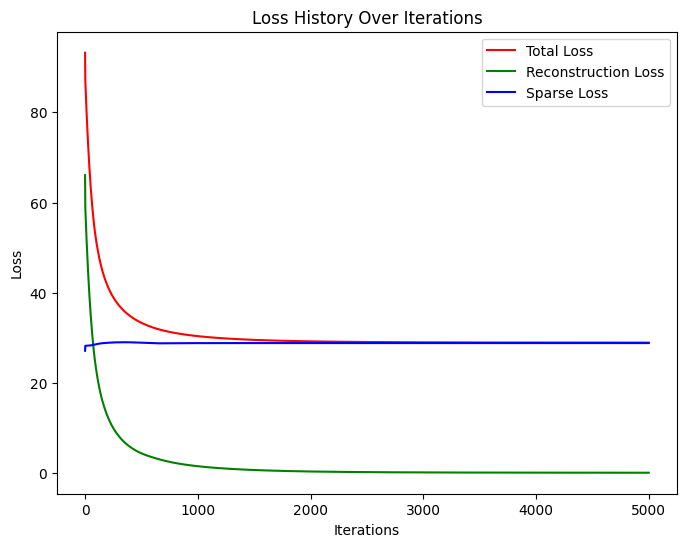

In [5]:
# Example use case with the existing variables
opt = ISTA(2.5, max_iter=5000)
eigs, _ = np.linalg.eig(A.T @ A)
alpha = max(eigs) + 100

# Optimize and recover the signal
z_recovered = opt.optimize(A, x, alpha)

# Visualize the loss history
opt.visualize_loss_history()

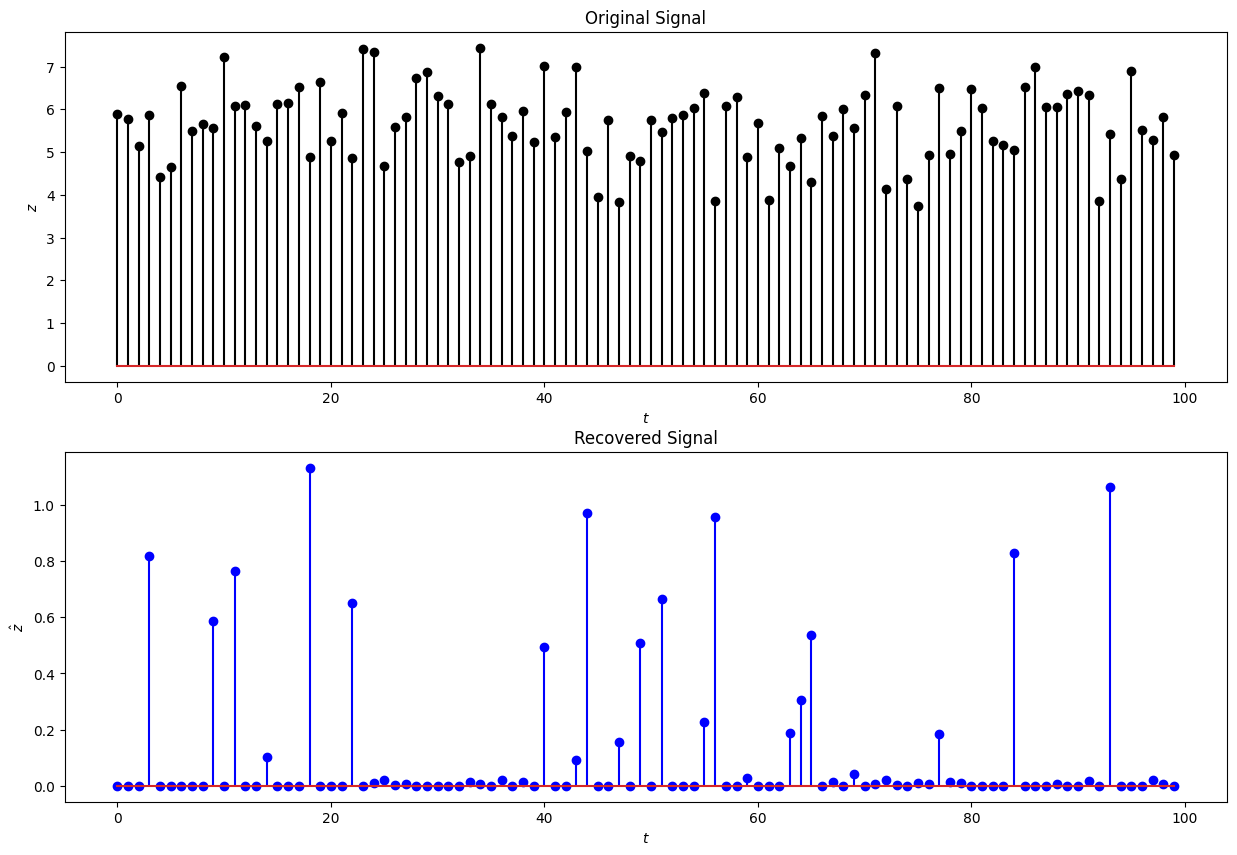

In [6]:
fig = plt.figure(dpi=100, figsize=(15, 10))
ax  = fig.subplots(2, 1)
_   = ax[0].stem(t, x, "k", label="Original Signal")
_   = ax[0].set_xlabel(r'$t$')
_   = ax[0].set_ylabel(r'$z$')
_   = ax[0].set_title("Original Signal")

_   = ax[1].stem(t, z_recovered, "b", label="Recovered Signal")
_   = ax[1].set_xlabel(r'$t$')
_   = ax[1].set_ylabel(r'$\hat{z}$')
_   = ax[1].set_title("Recovered Signal")

### Task 3.2

Add in your response to Task 3.2 from the manual in the cells below.

Testing for sparsity level: 10.0%
Testing for sparsity level: 20.0%
Testing for sparsity level: 30.000000000000004%
Testing for sparsity level: 40.0%
Testing for sparsity level: 50.0%
Testing for sparsity level: 60.0%
Testing for sparsity level: 70.0%
Testing for sparsity level: 80.0%
Testing for sparsity level: 90.0%


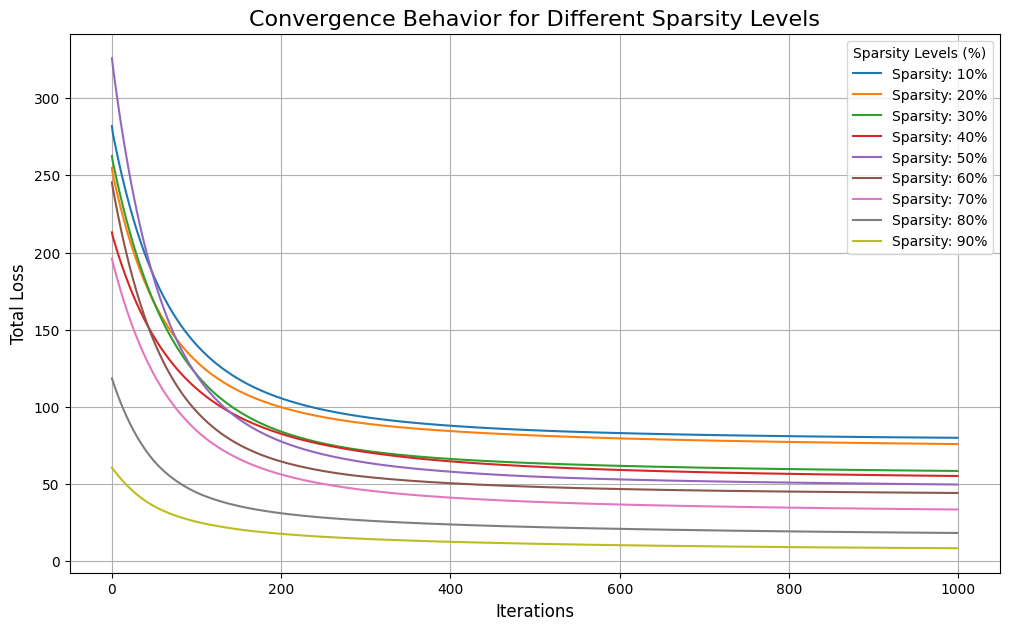

Results Table:


,Sparsity Level (%),Final Reconstruction Loss,Final Sparse Loss,Final Total Loss,Recovered Signal Sparsity (%)
0,10.000000,2.4955,77.5175,80.0130,98.00
1,20.000000,4.2992,71.6650,75.9642,96.00
2,30.000000,3.0135,55.5310,58.5445,95.00
3,40.000000,3.7584,51.5261,55.2845,90.00
4,50.000000,3.5350,46.2208,49.7558,82.00
5,60.000000,3.5721,40.7003,44.2724,84.00
6,70.000000,3.2124,30.3652,33.5776,74.00
7,80.000000,1.9730,16.4079,18.3810,58.00
8,90.000000,0.8711,7.6240,8.4950,45.00


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Function to generate a sparse signal with varying sparsity levels
def generate_sparse_signal(length, sparsity_level):
    z = 1.5 * np.random.rand(length)
    z = z * np.array([0 if np.random.rand() < sparsity_level else 1 for _ in range(length)])
    return z

# Expanded Sparsity Levels to test
sparsity_levels = np.arange(0.1, 1.0, 0.1)  # From 10% to 90% sparsity
results = []

# ISTA Parameters
lambd = 1.2
max_iter = 1000
eigs, _ = np.linalg.eig(A.T @ A)
alpha = max(eigs) + 10  # Alpha should be slightly greater than max eigenvalue

plt.figure(figsize=(12, 7))

# Loop over different sparsity levels
for sparsity_level in sparsity_levels:
    print(f"Testing for sparsity level: {sparsity_level * 100}%")

    # Generate sparse signal
    z = generate_sparse_signal(length=100, sparsity_level=sparsity_level)

    # Generate noisy observation x
    noise = np.random.normal(0, sigma, size=z.shape)
    x = A @ z + noise

    # Initialize and run ISTA
    opt = ISTA(lambd=lambd, max_iter=max_iter)
    z_recovered = opt.optimize(A, x, alpha)

    # Store the final losses for table creation
    final_reconstruction_loss = opt.loss_history_reconstruction[-1]
    final_sparse_loss = opt.loss_history_sparse[-1]
    final_total_loss = opt.loss_history_combined[-1]
    sparsity_in_recovered = np.sum(np.abs(z_recovered) > 1e-3) / len(z_recovered)  # Measure sparsity in recovered signal

    results.append({
        "Sparsity Level (%)": sparsity_level * 100,
        "Final Reconstruction Loss": final_reconstruction_loss,
        "Final Sparse Loss": final_sparse_loss,
        "Final Total Loss": final_total_loss,
        "Recovered Signal Sparsity (%)": sparsity_in_recovered * 100  # As percentage
    })

    # Plot the loss history (total loss)
    plt.plot(opt.loss_history_combined, label=f"Sparsity: {int(sparsity_level * 100)}%")

# Enhance Graph Aesthetics
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Total Loss', fontsize=12)
plt.title('Convergence Behavior for Different Sparsity Levels', fontsize=16)
plt.legend(title="Sparsity Levels (%)", fontsize=10)
plt.grid(True)
plt.show()

# Create a DataFrame to show the results in tabular form
results_df = pd.DataFrame(results)

# Enhanced Table Display
styled_table = results_df.style.set_properties(**{
    'background-color': '#f2f2f2',
    'color': 'black',
    'border-color': 'black',
}).set_table_styles([{
    'selector': 'thead th',
    'props': [('background-color', '#404040'), ('color', 'white'), ('font-size', '14px')]
}]).format({
    'Final Reconstruction Loss': '{:.4f}',
    'Final Sparse Loss': '{:.4f}',
    'Final Total Loss': '{:.4f}',
    'Recovered Signal Sparsity (%)': '{:.2f}'
})

# Display the styled table
print("Results Table:")
styled_table


## ISTA Convergence and Recovery for Varying Sparsity Levels

In this experiment, we explored how the convergence behavior and the recovery of the underlying vector \( \mathbf{z} \) are affected by varying its sparsity level during generation. We tested a wide range of sparsity levels, from 10% to 90%, using the Iterative Soft Thresholding Algorithm (ISTA) to recover a sparse signal \( \mathbf{z} \) from noisy observations \( \mathbf{x} \). For each sparsity level, we generated a random signal where a specific percentage of values were set to zero, and Gaussian noise was added to simulate real-world measurements. The graph below illustrates the convergence of the **total loss** over iterations for each sparsity level. As the sparsity level increased, ISTA generally required more iterations to converge, especially for signals with higher sparsity (e.g., 80%-90%).

In addition to convergence, we also evaluated the recovery performance by comparing the original sparsity of the signal with the sparsity of the recovered signal. The results, shown in the table below, indicate that as the sparsity level increases, the sparse loss component becomes more prominent in the total loss. For low sparsity levels (e.g., 10%-30%), the reconstruction loss is the dominant factor, whereas for higher sparsity levels (e.g., 70%-90%), the sparse loss contributes more to the total loss. The recovered signal generally becomes sparser as the original signal’s sparsity increases, indicating that ISTA successfully enforces sparsity in the recovery process. However, higher sparsity also leads to slower convergence, as ISTA has to work harder to enforce the sparsity constraints. Overall, this analysis highlights how varying the sparsity level influences both the speed of convergence and the accuracy of signal recovery using ISTA.


## Section 2: Unfolding

In section 1, we had the luxury of knowing what our measurement matrix $A$ was. Yet, we had to choose values of $\alpha$ and $\lambda$ manually and a little experimentation will show you that their choice impacts the performance of the algorithm greatly. Our new problem setup assumes that we only have access to some noisy measurements $\mathbf{z}$ and our objective is to recover the underlying sparse signal $\mathbf{z}$ with no knowledge of $\mathbf{A}$.

To do so, we turn our attention towards neural networks.


The following code will help you load and create a dataset from the given `sparse_signals.pkl` file. Do not change it.

The training data comprises of 9000 input $\mathbf{z} \in \mathbb{R}^{100}$ and output $\mathbf{x} \in \mathbb{R}^{100}$ signal pairs while test set contains 1000 samples.

In [8]:
class SparseSignalsDataset(Dataset):
  def __init__(self, Z, X):
    self.z = torch.tensor(np.array(Z), dtype=torch.float32)
    self.x = torch.tensor(np.array(X), dtype=torch.float32)

  def __len__(self):
    return len(self.z)

  def __getitem__(self, idx):
    return self.z[idx], self.x[idx]

In [9]:
def load_file(filename='signals.pkl'):
    with open(filename, 'rb') as f:
        Z, X = pickle.load(f)
    return Z, X

In [10]:
# DO NOT MODIFY
filename = "/content/drive/MyDrive/sparse_signals.pkl"
Z, X = load_file(filename=filename)
dataset = SparseSignalsDataset(Z, X)

batch_size = 32

train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=gen)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=gen)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Task 3.3

Refer to the manual for this task.

In [11]:
def visualize(model, test_loader, num_samples, configs):
    model.eval()
    fig = plt.figure(figsize=(12, 5))
    axs = fig.subplots(2, num_samples)
    t = np.arange(0, 100, 1)
    with torch.no_grad():
        for i, (z, x) in enumerate(test_loader):
            if i == num_samples:
                break
            z, x = z.to(configs["device"]), x.to(configs["device"])
            z_hat = model(x)[0, :].cpu().numpy()  # Model generates z_hat, the recovered signal
            z = z[0, :].cpu().numpy()  # Original sparse signal

            # Plot original signal
            _ = axs[0, i].stem(t, z, "k")
            _ = axs[0, i].set_xlabel(r'$t$')
            _ = axs[0, i].set_ylabel(r'$z$')
            _ = axs[0, i].set_title("Original Signal")

            # Plot recovered signal
            _ = axs[1, i].stem(t, z_hat, "b")
            _ = axs[1, i].set_xlabel(r'$t$')
            _ = axs[1, i].set_ylabel(r'$\hat{z}$')
            _ = axs[1, i].set_title("Recovered Signal")
    plt.tight_layout()
    plt.show()
    return axs


In [12]:
# Ignore the use of x, y here - those are just placeholders

def train(model, train_loader, loss_fn, optimizer, configs):
    model.train()
    loss_history = []  # To store loss for each epoch
    for epoch in range(configs["epochs"]):
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(configs["device"]), y.to(configs["device"])
            optimizer.zero_grad()
            x_hat = model(y)  # Recovered signal from the model
            loss = loss_fn(x_hat, x)  # Loss between recovered and original signal
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * y.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        loss_history.append(epoch_loss)  # Append the epoch loss to the history
        print(f"Epoch: [{epoch+1}/{configs['epochs']}], Loss: {epoch_loss:.4f}")

    # Plot the training loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(loss_history, label='Training Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()


def evaluate(model, test_loader, loss_fn, configs, tol=1e-6):
    model.eval()
    running_loss = 0.0
    sparsities = []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(configs["device"]), y.to(configs["device"])
            x_hat = model(y)  # Recovered signal
            loss = loss_fn(x_hat, x)  # MSE loss between original and recovered signal
            running_loss += loss.item() * y.size(0)

            # Calculate sparsity of the recovered signal based on a tolerance level
            sparsities.append(torch.sum(torch.abs(x_hat) < tol).item() / x_hat.numel())

    # Average loss and sparsity across the test set
    avg_loss = running_loss / len(test_loader.dataset)
    avg_sparsity = np.mean(sparsities)

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Average Sparsity: {avg_sparsity:.4f}")

    return avg_loss, avg_sparsity


In [13]:
class ISTABlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        """Initialize the ISTA block with a learnable threshold and a linear layer."""

        super(ISTABlock, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.threshold = nn.Parameter(torch.Tensor([0.1]))  # Learnable threshold parameter

    def _soft(self, x, T):
        """Apply soft-thresholding with threshold T."""

        return torch.sign(x) * torch.relu(torch.abs(x) - T)

    def forward(self, x):
        """Perform the forward pass through the ISTA block."""

        z = self.linear(x)  # Linear transformation
        z = self._soft(z, self.threshold)  # Apply soft-thresholding
        return z


class UnfoldedNN(nn.Module):
    def __init__(self, configs):
        """Initialize the unfolded neural network with multiple ISTA blocks."""

        super(UnfoldedNN, self).__init__()
        input_dim = configs["input_dim"]
        hidden_dims = configs["hidden_dims"]
        output_dim = configs["output_dim"]

        # Create the sequence of ISTA blocks
        self.ista_blocks = nn.ModuleList()
        previous_dim = input_dim

        for hidden_dim in hidden_dims:
            self.ista_blocks.append(ISTABlock(previous_dim, hidden_dim))
            previous_dim = hidden_dim

        # Output layer
        self.ista_blocks.append(ISTABlock(previous_dim, output_dim))


    def forward(self, x):
        """Perform the forward pass through the unfolded neural network."""

        for block in self.ista_blocks:
            x = block(x)  # Pass through each ISTA block
        return x

In [14]:
configs_unfolded = {
    "input_dim": 100,
    "hidden_dims": [256, 256],
    "output_dim": 100,
    "lr": 1e-4,
    "epochs": 30,
    "batch_size": 32,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

Epoch: [1/30], Loss: 0.1722
Epoch: [2/30], Loss: 0.1481
Epoch: [3/30], Loss: 0.1411
Epoch: [4/30], Loss: 0.1315
Epoch: [5/30], Loss: 0.1198
Epoch: [6/30], Loss: 0.1064
Epoch: [7/30], Loss: 0.0921
Epoch: [8/30], Loss: 0.0790
Epoch: [9/30], Loss: 0.0684
Epoch: [10/30], Loss: 0.0608
Epoch: [11/30], Loss: 0.0554
Epoch: [12/30], Loss: 0.0514
Epoch: [13/30], Loss: 0.0485
Epoch: [14/30], Loss: 0.0464
Epoch: [15/30], Loss: 0.0448
Epoch: [16/30], Loss: 0.0437
Epoch: [17/30], Loss: 0.0427
Epoch: [18/30], Loss: 0.0419
Epoch: [19/30], Loss: 0.0413
Epoch: [20/30], Loss: 0.0407
Epoch: [21/30], Loss: 0.0402
Epoch: [22/30], Loss: 0.0399
Epoch: [23/30], Loss: 0.0396
Epoch: [24/30], Loss: 0.0392
Epoch: [25/30], Loss: 0.0390
Epoch: [26/30], Loss: 0.0387
Epoch: [27/30], Loss: 0.0386
Epoch: [28/30], Loss: 0.0383
Epoch: [29/30], Loss: 0.0382
Epoch: [30/30], Loss: 0.0380


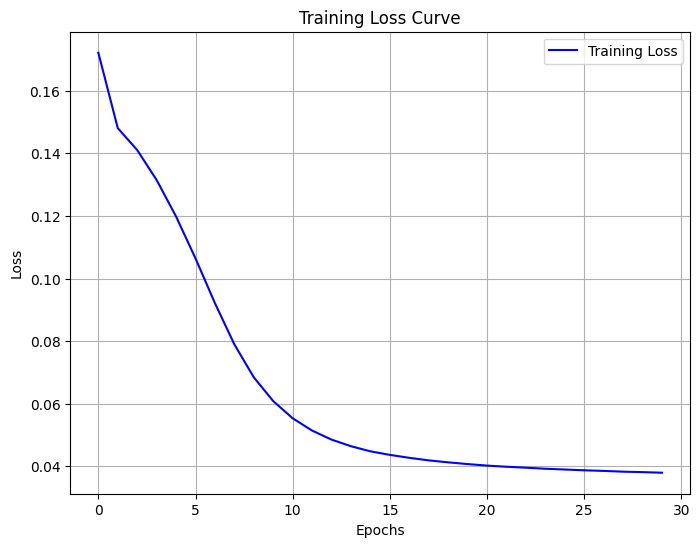

In [15]:
# Create the model
model_unfolded = UnfoldedNN(configs_unfolded).to(configs_unfolded["device"])

# Define optimizer and loss function
optimizer = torch.optim.Adam(model_unfolded.parameters(), lr=configs_unfolded["lr"])
L1 = nn.L1Loss()

# Train the unfolded neural network
train(model=model_unfolded, train_loader=train_loader, loss_fn=L1, optimizer=optimizer, configs=configs_unfolded)

Test Loss: 0.0389
Average Sparsity: 0.7647


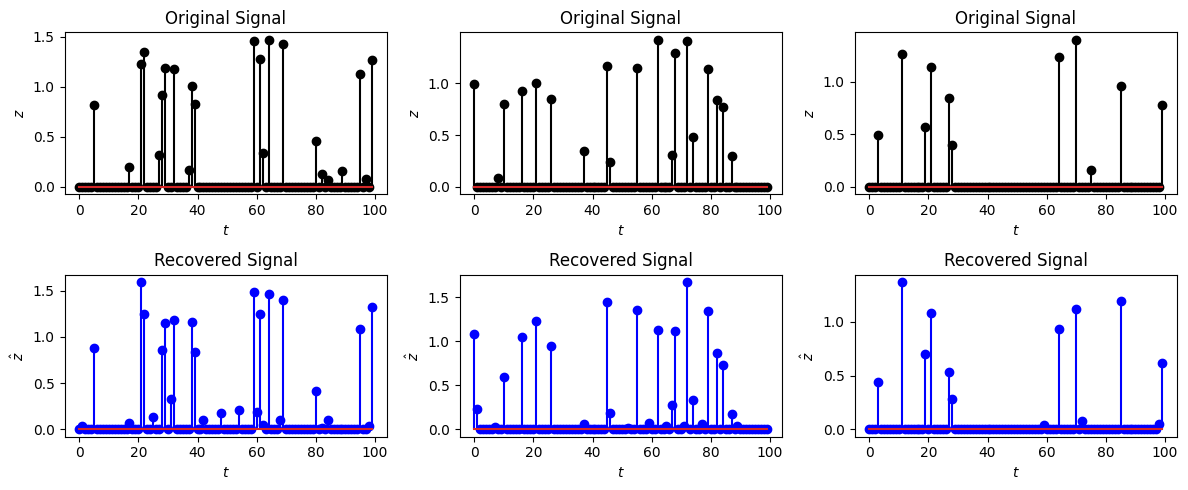

In [16]:
# Evaluate the model
avg_eval_loss_unfolded, avg_eval_sparsity_unfolded = evaluate(model_unfolded, test_loader, L1, configs_unfolded)

# Visualize the results for some test samples
_ = visualize(model_unfolded, test_loader, 3, configs_unfolded)

In [17]:
total_params = sum(p.numel() for p in model_unfolded.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

Total number of trainable parameters: 117351


# Experimenting with Depth , Optimizers and Learning Rates

We will experiment with:

- Depth: Vary the number of hidden layers in the UnfoldedNN (e.g., [256, 256], [512, 512], etc.).
- Optimizers: Use different optimizers (e.g., Adam, SGD).
- Learning Rates: Try different learning rates (e.g., 1e-3, 1e-4).

Running experiment with depth: [256, 256], optimizer: Adam, learning rate: 0.0001
Epoch: [1/30], Loss: 0.1729
Epoch: [2/30], Loss: 0.1473
Epoch: [3/30], Loss: 0.1396
Epoch: [4/30], Loss: 0.1299
Epoch: [5/30], Loss: 0.1184
Epoch: [6/30], Loss: 0.1054
Epoch: [7/30], Loss: 0.0919
Epoch: [8/30], Loss: 0.0793
Epoch: [9/30], Loss: 0.0693
Epoch: [10/30], Loss: 0.0622
Epoch: [11/30], Loss: 0.0571
Epoch: [12/30], Loss: 0.0534
Epoch: [13/30], Loss: 0.0506
Epoch: [14/30], Loss: 0.0486
Epoch: [15/30], Loss: 0.0471
Epoch: [16/30], Loss: 0.0459
Epoch: [17/30], Loss: 0.0449
Epoch: [18/30], Loss: 0.0438
Epoch: [19/30], Loss: 0.0429
Epoch: [20/30], Loss: 0.0421
Epoch: [21/30], Loss: 0.0412
Epoch: [22/30], Loss: 0.0404
Epoch: [23/30], Loss: 0.0399
Epoch: [24/30], Loss: 0.0394
Epoch: [25/30], Loss: 0.0391
Epoch: [26/30], Loss: 0.0388
Epoch: [27/30], Loss: 0.0386
Epoch: [28/30], Loss: 0.0383
Epoch: [29/30], Loss: 0.0382
Epoch: [30/30], Loss: 0.0380


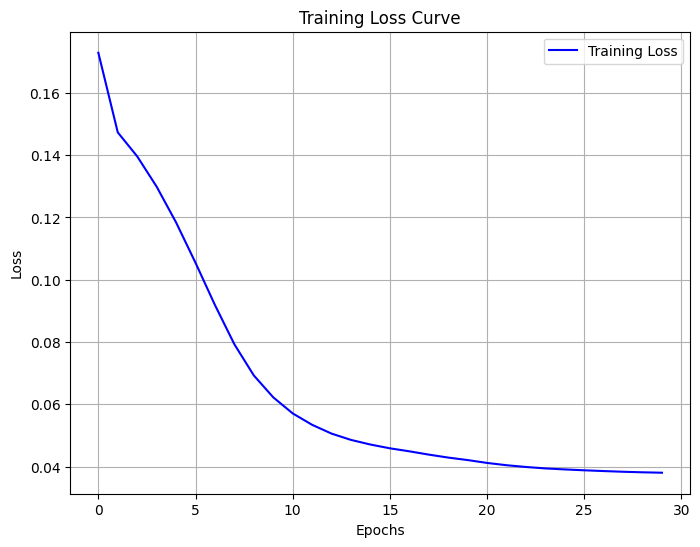

Test Loss: 0.0389
Average Sparsity: 0.7648
Running experiment with depth: [256, 256], optimizer: SGD, learning rate: 0.0001
Epoch: [1/30], Loss: 0.2590
Epoch: [2/30], Loss: 0.1868
Epoch: [3/30], Loss: 0.1687
Epoch: [4/30], Loss: 0.1616
Epoch: [5/30], Loss: 0.1581
Epoch: [6/30], Loss: 0.1560
Epoch: [7/30], Loss: 0.1547
Epoch: [8/30], Loss: 0.1538
Epoch: [9/30], Loss: 0.1532
Epoch: [10/30], Loss: 0.1527
Epoch: [11/30], Loss: 0.1523
Epoch: [12/30], Loss: 0.1520
Epoch: [13/30], Loss: 0.1518
Epoch: [14/30], Loss: 0.1516
Epoch: [15/30], Loss: 0.1514
Epoch: [16/30], Loss: 0.1513
Epoch: [17/30], Loss: 0.1512
Epoch: [18/30], Loss: 0.1511
Epoch: [19/30], Loss: 0.1510
Epoch: [20/30], Loss: 0.1509
Epoch: [21/30], Loss: 0.1508
Epoch: [22/30], Loss: 0.1508
Epoch: [23/30], Loss: 0.1507
Epoch: [24/30], Loss: 0.1507
Epoch: [25/30], Loss: 0.1506
Epoch: [26/30], Loss: 0.1506
Epoch: [27/30], Loss: 0.1505
Epoch: [28/30], Loss: 0.1505
Epoch: [29/30], Loss: 0.1505
Epoch: [30/30], Loss: 0.1504


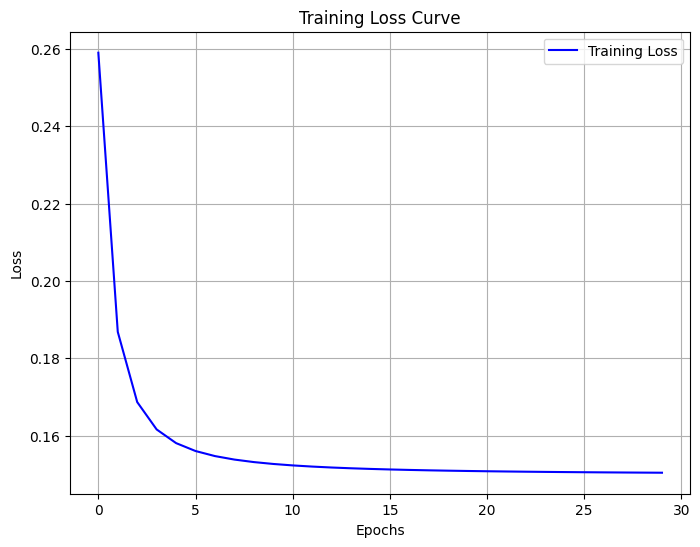

Test Loss: 0.1505
Average Sparsity: 0.9893
Running experiment with depth: [256, 256], optimizer: Adam, learning rate: 0.001
Epoch: [1/30], Loss: 0.1351
Epoch: [2/30], Loss: 0.0655
Epoch: [4/30], Loss: 0.0493
Epoch: [5/30], Loss: 0.0480
Epoch: [6/30], Loss: 0.0473
Epoch: [7/30], Loss: 0.0472
Epoch: [8/30], Loss: 0.0468
Epoch: [9/30], Loss: 0.0468
Epoch: [10/30], Loss: 0.0467
Epoch: [11/30], Loss: 0.0465
Epoch: [12/30], Loss: 0.0466
Epoch: [13/30], Loss: 0.0466
Epoch: [14/30], Loss: 0.0465
Epoch: [15/30], Loss: 0.0467
Epoch: [16/30], Loss: 0.0468
Epoch: [17/30], Loss: 0.0467
Epoch: [18/30], Loss: 0.0466
Epoch: [19/30], Loss: 0.0466
Epoch: [20/30], Loss: 0.0467
Epoch: [21/30], Loss: 0.0465
Epoch: [22/30], Loss: 0.0466
Epoch: [23/30], Loss: 0.0465
Epoch: [24/30], Loss: 0.0465
Epoch: [25/30], Loss: 0.0466
Epoch: [26/30], Loss: 0.0467
Epoch: [27/30], Loss: 0.0465
Epoch: [28/30], Loss: 0.0465
Epoch: [29/30], Loss: 0.0464
Epoch: [30/30], Loss: 0.0464


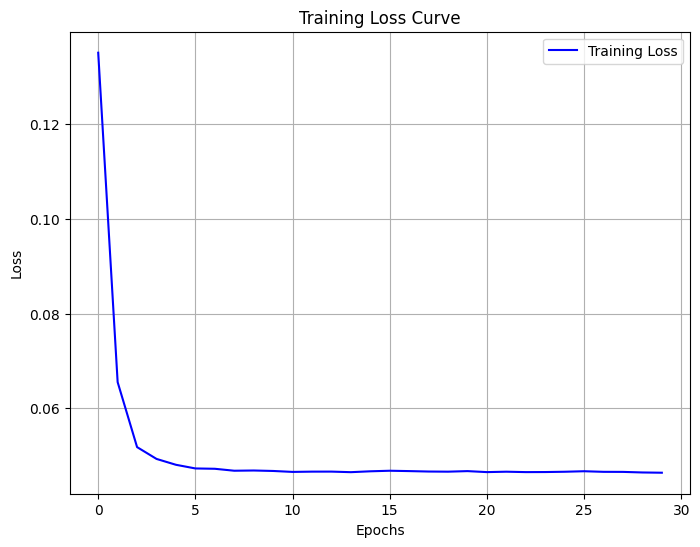

Test Loss: 0.0457
Average Sparsity: 0.7888
Running experiment with depth: [256, 256], optimizer: SGD, learning rate: 0.001
Epoch: [1/30], Loss: 0.1744
Epoch: [2/30], Loss: 0.1514
Epoch: [3/30], Loss: 0.1506
Epoch: [4/30], Loss: 0.1503
Epoch: [5/30], Loss: 0.1502
Epoch: [6/30], Loss: 0.1501
Epoch: [7/30], Loss: 0.1501
Epoch: [8/30], Loss: 0.1500
Epoch: [9/30], Loss: 0.1500
Epoch: [10/30], Loss: 0.1500
Epoch: [11/30], Loss: 0.1500
Epoch: [12/30], Loss: 0.1499
Epoch: [13/30], Loss: 0.1499
Epoch: [14/30], Loss: 0.1499
Epoch: [15/30], Loss: 0.1499
Epoch: [16/30], Loss: 0.1499
Epoch: [17/30], Loss: 0.1499
Epoch: [18/30], Loss: 0.1499
Epoch: [19/30], Loss: 0.1499
Epoch: [20/30], Loss: 0.1499
Epoch: [21/30], Loss: 0.1499
Epoch: [22/30], Loss: 0.1499
Epoch: [23/30], Loss: 0.1499
Epoch: [24/30], Loss: 0.1499
Epoch: [25/30], Loss: 0.1499
Epoch: [26/30], Loss: 0.1499
Epoch: [27/30], Loss: 0.1499
Epoch: [28/30], Loss: 0.1499
Epoch: [29/30], Loss: 0.1499
Epoch: [30/30], Loss: 0.1499


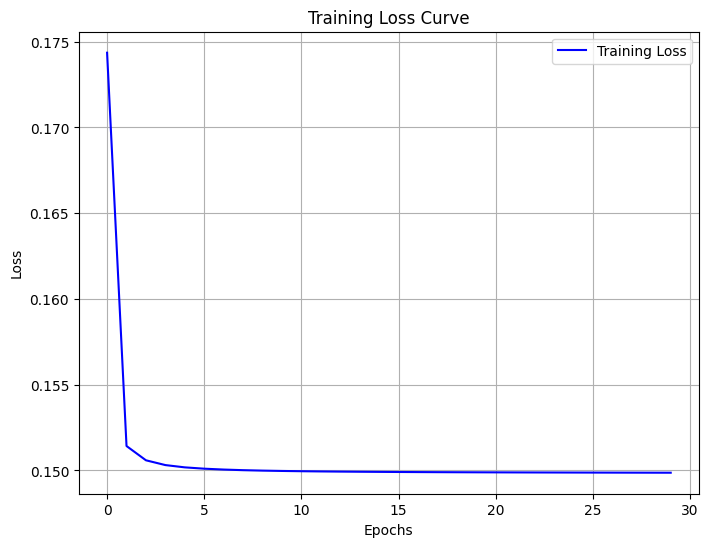

Test Loss: 0.1500
Average Sparsity: 0.9985
Running experiment with depth: [512, 512], optimizer: Adam, learning rate: 0.0001
Epoch: [1/30], Loss: 0.1597
Epoch: [2/30], Loss: 0.1318
Epoch: [3/30], Loss: 0.1105
Epoch: [4/30], Loss: 0.0889
Epoch: [5/30], Loss: 0.0712
Epoch: [6/30], Loss: 0.0603
Epoch: [7/30], Loss: 0.0535
Epoch: [8/30], Loss: 0.0493
Epoch: [9/30], Loss: 0.0466
Epoch: [10/30], Loss: 0.0448
Epoch: [11/30], Loss: 0.0435
Epoch: [12/30], Loss: 0.0424
Epoch: [13/30], Loss: 0.0417
Epoch: [14/30], Loss: 0.0411
Epoch: [15/30], Loss: 0.0405
Epoch: [16/30], Loss: 0.0401
Epoch: [17/30], Loss: 0.0398
Epoch: [18/30], Loss: 0.0395
Epoch: [19/30], Loss: 0.0393
Epoch: [20/30], Loss: 0.0391
Epoch: [21/30], Loss: 0.0389
Epoch: [22/30], Loss: 0.0387
Epoch: [23/30], Loss: 0.0386
Epoch: [24/30], Loss: 0.0385
Epoch: [25/30], Loss: 0.0384
Epoch: [26/30], Loss: 0.0383
Epoch: [27/30], Loss: 0.0382
Epoch: [28/30], Loss: 0.0381
Epoch: [29/30], Loss: 0.0381
Epoch: [30/30], Loss: 0.0381


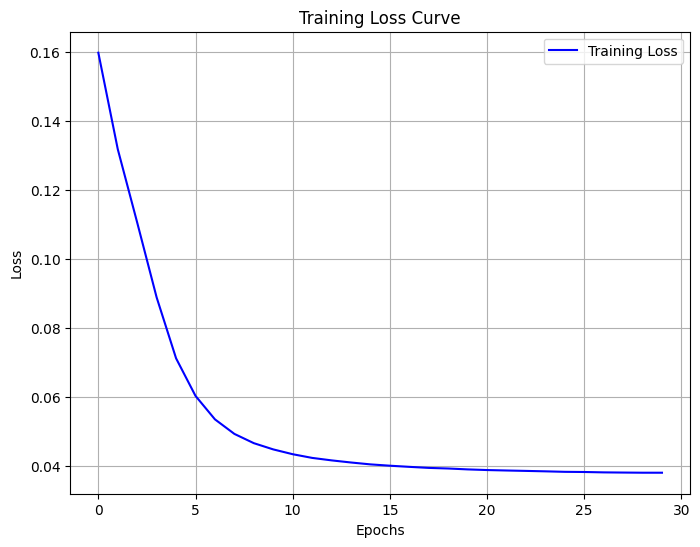

Test Loss: 0.0386
Average Sparsity: 0.7714
Running experiment with depth: [512, 512], optimizer: SGD, learning rate: 0.0001
Epoch: [1/30], Loss: 0.2478
Epoch: [2/30], Loss: 0.1826
Epoch: [3/30], Loss: 0.1678
Epoch: [4/30], Loss: 0.1614
Epoch: [5/30], Loss: 0.1580
Epoch: [6/30], Loss: 0.1560
Epoch: [7/30], Loss: 0.1546
Epoch: [8/30], Loss: 0.1537
Epoch: [9/30], Loss: 0.1531
Epoch: [10/30], Loss: 0.1526
Epoch: [11/30], Loss: 0.1522
Epoch: [12/30], Loss: 0.1519
Epoch: [13/30], Loss: 0.1516
Epoch: [14/30], Loss: 0.1514
Epoch: [15/30], Loss: 0.1513
Epoch: [16/30], Loss: 0.1511
Epoch: [17/30], Loss: 0.1510
Epoch: [18/30], Loss: 0.1509
Epoch: [19/30], Loss: 0.1508
Epoch: [20/30], Loss: 0.1508
Epoch: [21/30], Loss: 0.1507
Epoch: [22/30], Loss: 0.1506
Epoch: [23/30], Loss: 0.1506
Epoch: [24/30], Loss: 0.1505
Epoch: [25/30], Loss: 0.1505
Epoch: [26/30], Loss: 0.1505
Epoch: [27/30], Loss: 0.1504
Epoch: [28/30], Loss: 0.1504
Epoch: [29/30], Loss: 0.1504
Epoch: [30/30], Loss: 0.1503


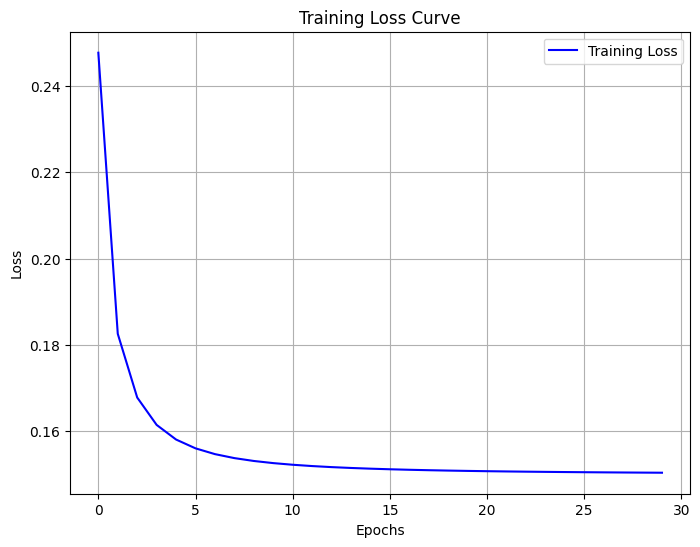

Test Loss: 0.1505
Average Sparsity: 0.9880
Running experiment with depth: [512, 512], optimizer: Adam, learning rate: 0.001
Epoch: [1/30], Loss: 0.1159
Epoch: [2/30], Loss: 0.0607
Epoch: [3/30], Loss: 0.0539
Epoch: [4/30], Loss: 0.0520
Epoch: [5/30], Loss: 0.0517
Epoch: [6/30], Loss: 0.0516
Epoch: [7/30], Loss: 0.0516
Epoch: [8/30], Loss: 0.0515
Epoch: [9/30], Loss: 0.0523
Epoch: [10/30], Loss: 0.0522
Epoch: [11/30], Loss: 0.0526
Epoch: [12/30], Loss: 0.0527
Epoch: [13/30], Loss: 0.0530
Epoch: [14/30], Loss: 0.0530
Epoch: [15/30], Loss: 0.0526
Epoch: [16/30], Loss: 0.0526
Epoch: [17/30], Loss: 0.0526
Epoch: [18/30], Loss: 0.0524
Epoch: [19/30], Loss: 0.0523
Epoch: [20/30], Loss: 0.0522
Epoch: [21/30], Loss: 0.0521
Epoch: [22/30], Loss: 0.0515
Epoch: [23/30], Loss: 0.0514
Epoch: [24/30], Loss: 0.0516
Epoch: [25/30], Loss: 0.0510
Epoch: [26/30], Loss: 0.0508
Epoch: [27/30], Loss: 0.0510
Epoch: [28/30], Loss: 0.0506
Epoch: [29/30], Loss: 0.0503
Epoch: [30/30], Loss: 0.0503


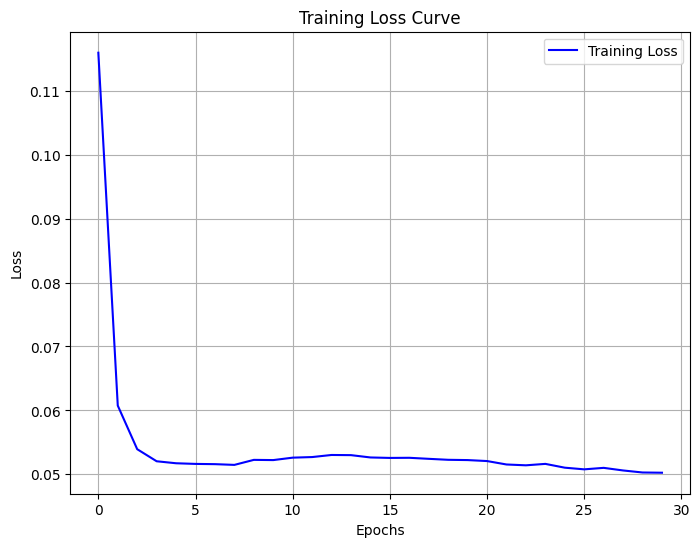

Test Loss: 0.0533
Average Sparsity: 0.7972
Running experiment with depth: [512, 512], optimizer: SGD, learning rate: 0.001
Epoch: [1/30], Loss: 0.1699
Epoch: [2/30], Loss: 0.1511
Epoch: [3/30], Loss: 0.1504
Epoch: [4/30], Loss: 0.1502
Epoch: [5/30], Loss: 0.1501
Epoch: [6/30], Loss: 0.1500
Epoch: [7/30], Loss: 0.1500
Epoch: [8/30], Loss: 0.1500
Epoch: [9/30], Loss: 0.1500
Epoch: [10/30], Loss: 0.1499
Epoch: [11/30], Loss: 0.1499
Epoch: [12/30], Loss: 0.1499
Epoch: [13/30], Loss: 0.1499
Epoch: [14/30], Loss: 0.1499
Epoch: [15/30], Loss: 0.1499
Epoch: [16/30], Loss: 0.1499
Epoch: [17/30], Loss: 0.1499
Epoch: [18/30], Loss: 0.1499
Epoch: [19/30], Loss: 0.1499
Epoch: [20/30], Loss: 0.1499
Epoch: [21/30], Loss: 0.1498
Epoch: [22/30], Loss: 0.1498
Epoch: [23/30], Loss: 0.1498
Epoch: [24/30], Loss: 0.1498
Epoch: [25/30], Loss: 0.1498
Epoch: [26/30], Loss: 0.1498
Epoch: [27/30], Loss: 0.1498
Epoch: [28/30], Loss: 0.1498
Epoch: [29/30], Loss: 0.1498
Epoch: [30/30], Loss: 0.1498


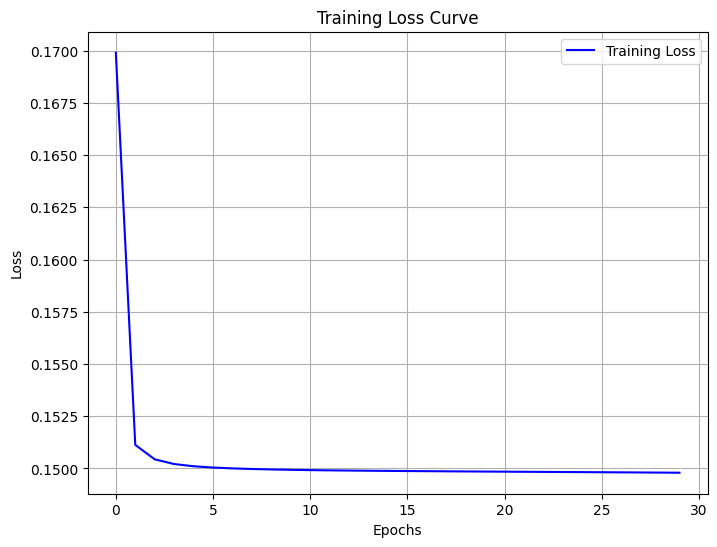

Test Loss: 0.1500
Average Sparsity: 0.9966
Running experiment with depth: [256, 512], optimizer: Adam, learning rate: 0.0001
Epoch: [1/30], Loss: 0.1644
Epoch: [2/30], Loss: 0.1400
Epoch: [3/30], Loss: 0.1252
Epoch: [4/30], Loss: 0.1088
Epoch: [5/30], Loss: 0.0916
Epoch: [6/30], Loss: 0.0762
Epoch: [7/30], Loss: 0.0652
Epoch: [8/30], Loss: 0.0582
Epoch: [9/30], Loss: 0.0535
Epoch: [10/30], Loss: 0.0504
Epoch: [11/30], Loss: 0.0482
Epoch: [12/30], Loss: 0.0465
Epoch: [13/30], Loss: 0.0453
Epoch: [14/30], Loss: 0.0443
Epoch: [15/30], Loss: 0.0436
Epoch: [16/30], Loss: 0.0426
Epoch: [17/30], Loss: 0.0416
Epoch: [18/30], Loss: 0.0411
Epoch: [19/30], Loss: 0.0407
Epoch: [20/30], Loss: 0.0403
Epoch: [21/30], Loss: 0.0401
Epoch: [22/30], Loss: 0.0398
Epoch: [23/30], Loss: 0.0396
Epoch: [24/30], Loss: 0.0394
Epoch: [25/30], Loss: 0.0393
Epoch: [26/30], Loss: 0.0391
Epoch: [27/30], Loss: 0.0390
Epoch: [28/30], Loss: 0.0389
Epoch: [29/30], Loss: 0.0389
Epoch: [30/30], Loss: 0.0388


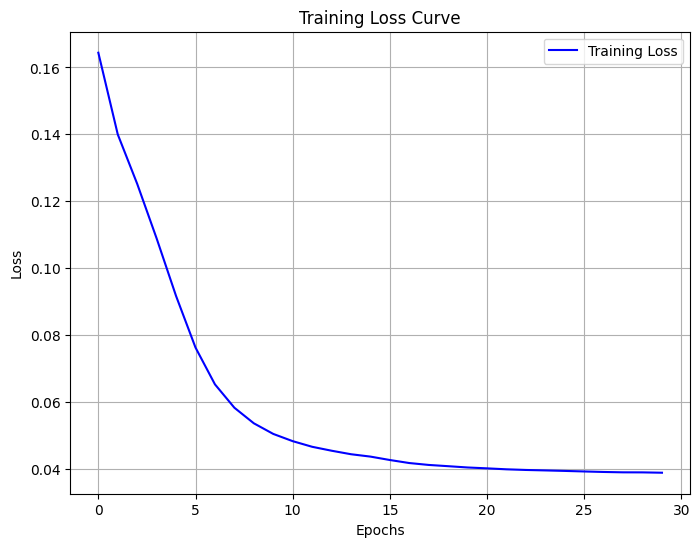

Test Loss: 0.0393
Average Sparsity: 0.7709
Running experiment with depth: [256, 512], optimizer: SGD, learning rate: 0.0001
Epoch: [1/30], Loss: 0.2557
Epoch: [2/30], Loss: 0.1846
Epoch: [3/30], Loss: 0.1681
Epoch: [4/30], Loss: 0.1616
Epoch: [5/30], Loss: 0.1582
Epoch: [6/30], Loss: 0.1562
Epoch: [7/30], Loss: 0.1549
Epoch: [8/30], Loss: 0.1540
Epoch: [9/30], Loss: 0.1533
Epoch: [10/30], Loss: 0.1528
Epoch: [11/30], Loss: 0.1524
Epoch: [12/30], Loss: 0.1521
Epoch: [13/30], Loss: 0.1518
Epoch: [14/30], Loss: 0.1516
Epoch: [15/30], Loss: 0.1514
Epoch: [16/30], Loss: 0.1513
Epoch: [17/30], Loss: 0.1512
Epoch: [18/30], Loss: 0.1511
Epoch: [19/30], Loss: 0.1510
Epoch: [20/30], Loss: 0.1509
Epoch: [21/30], Loss: 0.1508
Epoch: [22/30], Loss: 0.1507
Epoch: [23/30], Loss: 0.1507
Epoch: [24/30], Loss: 0.1506
Epoch: [25/30], Loss: 0.1506
Epoch: [26/30], Loss: 0.1505
Epoch: [27/30], Loss: 0.1505
Epoch: [28/30], Loss: 0.1505
Epoch: [29/30], Loss: 0.1504
Epoch: [30/30], Loss: 0.1504


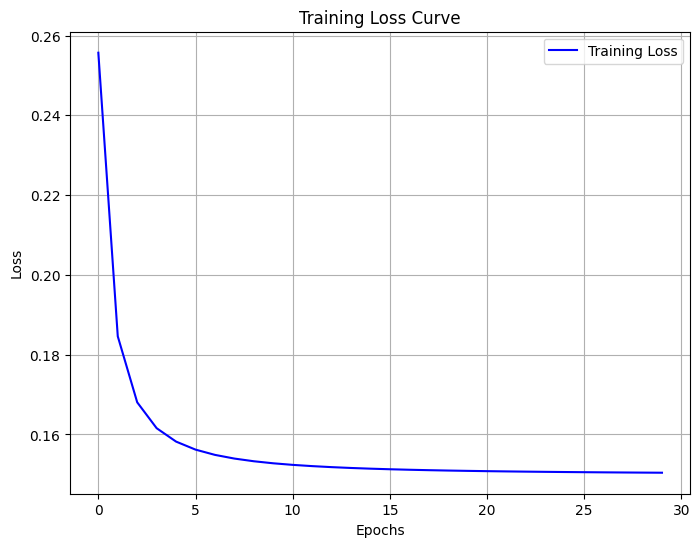

Test Loss: 0.1505
Average Sparsity: 0.9884
Running experiment with depth: [512, 512, 512], optimizer: Adam, learning rate: 0.0001
Epoch: [1/30], Loss: 0.1502
Epoch: [2/30], Loss: 0.1353
Epoch: [3/30], Loss: 0.1084
Epoch: [4/30], Loss: 0.0826
Epoch: [5/30], Loss: 0.0658


KeyboardInterrupt: 

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from tabulate import tabulate

# Experiment configurations: all combinations of depth, optimizer, and learning rate
experiment_configs = [
    {"depth": [256, 256], "optimizer": "Adam", "lr": 1e-4},
    {"depth": [256, 256], "optimizer": "SGD", "lr": 1e-4},
    {"depth": [256, 256], "optimizer": "Adam", "lr": 1e-3},
    {"depth": [256, 256], "optimizer": "SGD", "lr": 1e-3},
    {"depth": [512, 512], "optimizer": "Adam", "lr": 1e-4},
    {"depth": [512, 512], "optimizer": "SGD", "lr": 1e-4},
    {"depth": [512, 512], "optimizer": "Adam", "lr": 1e-3},
    {"depth": [512, 512], "optimizer": "SGD", "lr": 1e-3},
    {"depth": [256, 512], "optimizer": "Adam", "lr": 1e-4},
    {"depth": [256, 512], "optimizer": "SGD", "lr": 1e-4},
    {"depth": [512, 512, 512], "optimizer": "Adam", "lr": 1e-4},
    {"depth": [512, 512, 512], "optimizer": "SGD", "lr": 1e-4},
    {"depth": [256, 256, 256, 256], "optimizer": "Adam", "lr": 1e-4},  # 4 layers
    {"depth": [512] * 5, "optimizer": "Adam", "lr": 1e-3},  # 5 layers

    # New combinations with layers ranging from 5 to 10
    {"depth": [256, 256, 256, 256, 256], "optimizer": "Adam", "lr": 1e-4},  # 5 layers
    {"depth": [256, 256, 256, 256, 256], "optimizer": "SGD", "lr": 1e-3},  # 5 layers
    {"depth": [512, 512, 512, 512, 512], "optimizer": "Adam", "lr": 1e-3},  # 5 layers
    {"depth": [512] * 6, "optimizer": "Adam", "lr": 1e-4},  # 6 layers
    {"depth": [512] * 7, "optimizer": "Adam", "lr": 1e-4},  # 7 layers
    {"depth": [512] * 8, "optimizer": "Adam", "lr": 1e-4},  # 8 layers
    {"depth": [512] * 9, "optimizer": "Adam", "lr": 1e-4},  # 9 layers
    {"depth": [512] * 10, "optimizer": "Adam", "lr": 1e-4},  # 10 layers
]

# Initialize a table to store results
results_table = []

# Function to train the model and track results
def train_and_evaluate(config):
    # Model configuration
    configs_unfolded = {
        "input_dim": 100,
        "hidden_dims": config["depth"],  # Varying depth
        "output_dim": 100,
        "lr": config["lr"],
        "epochs": 30,
        "batch_size": 32,
        "device": "cuda" if torch.cuda.is_available() else "cpu"
    }

    # Create the model
    model_unfolded = UnfoldedNN(configs_unfolded).to(configs_unfolded["device"])

    # Select optimizer
    if config["optimizer"] == "Adam":
        optimizer = optim.Adam(model_unfolded.parameters(), lr=configs_unfolded["lr"])
    elif config["optimizer"] == "SGD":
        optimizer = optim.SGD(model_unfolded.parameters(), lr=configs_unfolded["lr"], momentum=0.9)

    # Loss function
    L1 = nn.L1Loss()

    # Train the model
    train(model=model_unfolded, train_loader=train_loader, loss_fn=L1, optimizer=optimizer, configs=configs_unfolded)

    # Evaluate the model
    avg_eval_loss, avg_eval_sparsity = evaluate(model_unfolded, test_loader, L1, configs_unfolded)

    # Store the results
    return avg_eval_loss, avg_eval_sparsity

# Run all experiments
for config in experiment_configs:
    print(f"Running experiment with depth: {config['depth']}, optimizer: {config['optimizer']}, learning rate: {config['lr']}")
    avg_loss, avg_sparsity = train_and_evaluate(config)
    results_table.append([config["depth"], config["optimizer"], config["lr"], avg_loss, avg_sparsity])

# Define the headers for the table
headers = ["Depth", "Optimizer", "Learning Rate", "Average Test Loss", "Average Sparsity"]

# Print the table using tabulate with a fancy format
print(tabulate(results_table, headers=headers, tablefmt="fancy_grid", numalign="center", stralign="center"))


### Task 3.4

Add in your solution to Task 3.4 from the manual in the cells below.

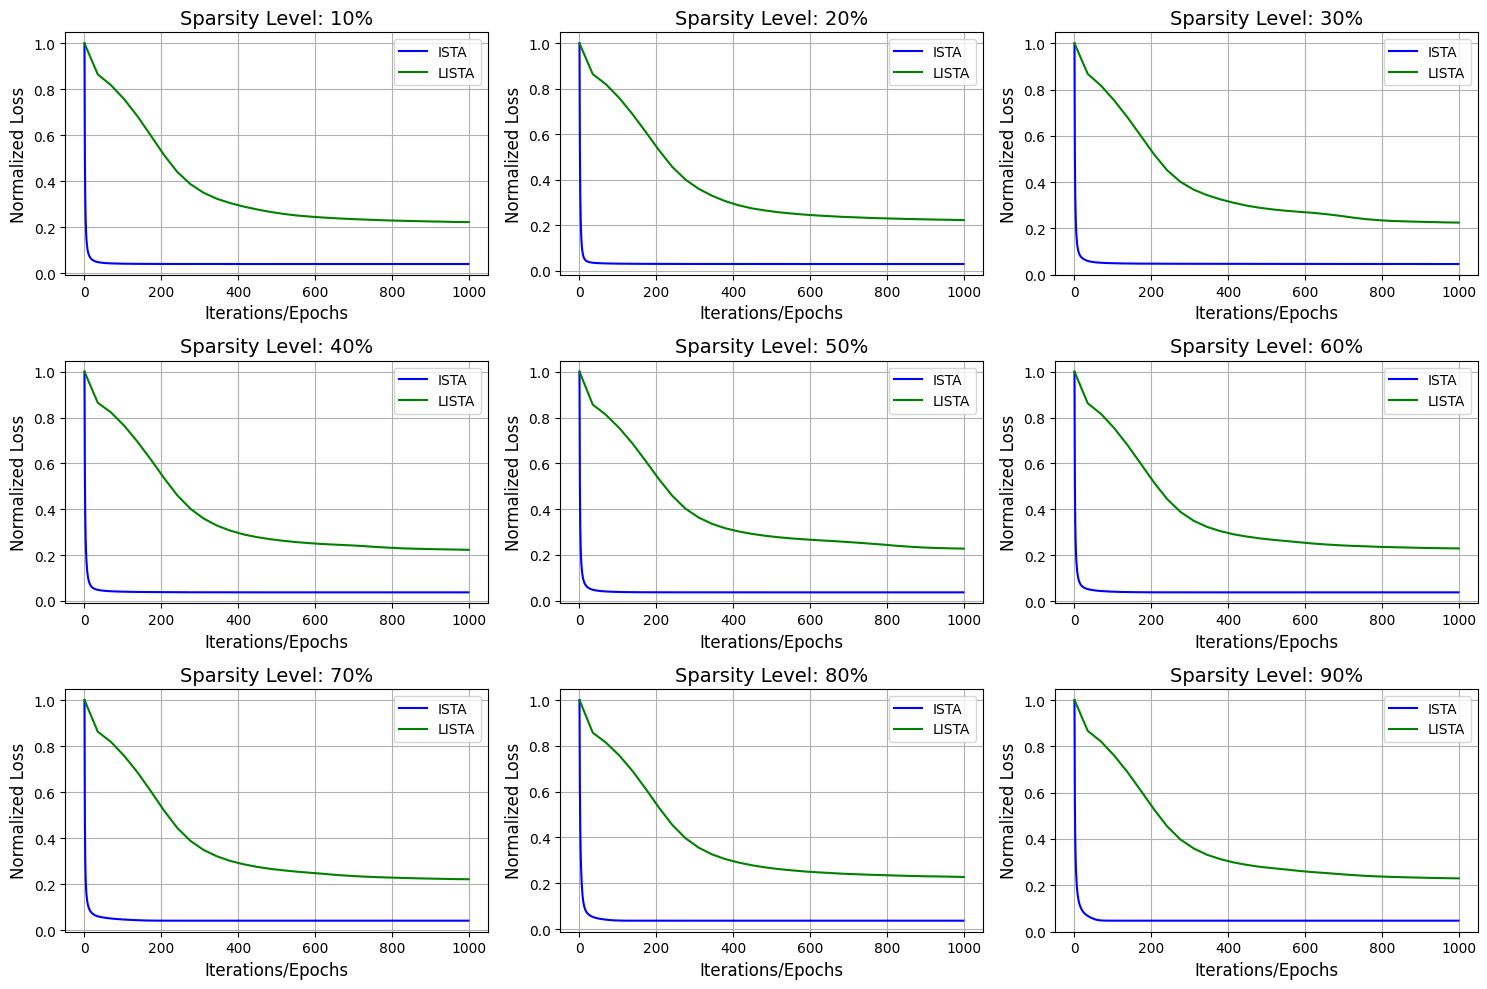

╒══════════════════╤═════════════════════╤══════════════════════╕
│  Sparsity Level  │  Average ISTA Loss  │  Average LISTA Loss  │
╞══════════════════╪═════════════════════╪══════════════════════╡
│       10%        │       71.5201       │      0.0647313       │
├──────────────────┼─────────────────────┼──────────────────────┤
│       20%        │       97.1289       │      0.0653583       │
├──────────────────┼─────────────────────┼──────────────────────┤
│       30%        │       67.4831       │      0.0660836       │
├──────────────────┼─────────────────────┼──────────────────────┤
│       40%        │       52.1389       │      0.0657222       │
├──────────────────┼─────────────────────┼──────────────────────┤
│       50%        │       57.9945       │      0.0673162       │
├──────────────────┼─────────────────────┼──────────────────────┤
│       60%        │       36.3287       │      0.0656243       │
├──────────────────┼─────────────────────┼──────────────────────┤
│       70

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from tabulate import tabulate

# Function to generate sparse signal with a given sparsity level
def generate_sparse_signal(length, sparsity_level):
    z = 1.5 * np.random.rand(length)
    z = z * np.array([0 if np.random.rand() < sparsity_level else 1 for _ in range(length)])
    return z

# Define a function for ISTA
class ISTA:
    def __init__(self, lambd, max_iter):
        self.lambd = lambd
        self.max_iter = max_iter
        self.loss_history = []

    def _soft_thresholding(self, z, threshold):
        return np.sign(z) * np.maximum(np.abs(z) - threshold, 0)

    def run(self, A, x, alpha):
        z = np.zeros(A.shape[1])
        for _ in range(self.max_iter):
            z_next = z + (1 / alpha) * A.T @ (x - A @ z)  # Gradient update
            z = self._soft_thresholding(z_next, self.lambd / alpha)
            loss = np.linalg.norm(x - A @ z)**2 + self.lambd * np.linalg.norm(z, 1)
            self.loss_history.append(loss)
        return z

# Function to train LISTA (Unfolded Neural Network)
def train_lista(model, train_loader, optimizer, loss_fn, configs):
    model.train()
    loss_history = []
    for epoch in range(configs['epochs']):
        running_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(configs['device']), y_batch.to(configs['device'])
            optimizer.zero_grad()
            output = model(y_batch)
            loss = loss_fn(output, x_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss_history.append(running_loss / len(train_loader))
    return loss_history

# Define sparsity levels to test
sparsity_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Prepare for plotting
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

# Initialize table to store average losses for ISTA and LISTA
results_table = []

# Loop through each sparsity level
for idx, sparsity_level in enumerate(sparsity_levels):
    # Generate sparse signal and noisy observations
    z_true = generate_sparse_signal(length=100, sparsity_level=sparsity_level)
    A = np.random.randn(100, 100)  # Random matrix A
    sigma = 0.05
    noise = np.random.normal(0, sigma, z_true.shape)
    x = A @ z_true + noise

    # ISTA Setup
    lambd = 1.2
    max_iter = 1000
    alpha = np.max(np.linalg.eigvals(A.T @ A)) + 10

    ista = ISTA(lambd, max_iter)
    z_ista = ista.run(A, x, alpha)

    # LISTA Setup
    configs_unfolded = {
        "input_dim": 100,
        "hidden_dims": [256, 256],
        "output_dim": 100,
        "lr": 1e-4,
        "epochs": 30,
        "batch_size": 32,
        "device": "cuda" if torch.cuda.is_available() else "cpu"
    }
    model_unfolded = UnfoldedNN(configs_unfolded).to(configs_unfolded["device"])

    # Define optimizer and loss function
    optimizer = optim.Adam(model_unfolded.parameters(), lr=configs_unfolded["lr"])
    L1 = nn.L1Loss()

    # Train LISTA and get loss history
    loss_history_lista = train_lista(model_unfolded, train_loader, optimizer, L1, configs_unfolded)

    # Normalize loss histories
    ista_loss_normalized = np.array(ista.loss_history) / np.max(ista.loss_history)
    lista_loss_normalized = np.array(loss_history_lista) / np.max(loss_history_lista)

    # Plot both ISTA and LISTA convergence curves
    axes[idx].plot(ista_loss_normalized, label="ISTA", color='blue')
    lista_x_axis = np.linspace(0, len(ista_loss_normalized), len(lista_loss_normalized))
    axes[idx].plot(lista_x_axis, lista_loss_normalized, label="LISTA", color='green')

    # Set plot labels and title
    axes[idx].set_title(f"Sparsity Level: {int(sparsity_level * 100)}%", fontsize=14)
    axes[idx].set_xlabel("Iterations/Epochs", fontsize=12)
    axes[idx].set_ylabel("Normalized Loss", fontsize=12)
    axes[idx].grid(True)
    axes[idx].legend()

    # Calculate and store average losses for both ISTA and LISTA
    avg_loss_ista = np.mean(ista.loss_history)
    avg_loss_lista = np.mean(loss_history_lista)
    results_table.append([f"{int(sparsity_level * 100)}%", avg_loss_ista, avg_loss_lista])

# Tight layout for the plot
plt.tight_layout()
plt.show()

# Define headers for the table
headers = ["Sparsity Level", "Average ISTA Loss", "Average LISTA Loss"]

# Print the table using tabulate
print(tabulate(results_table, headers=headers, tablefmt="fancy_grid", numalign="center", stralign="center"))


## Comparison of ISTA and LISTA Convergence for Varying Sparsity Levels

### Overview:
The table below summarizes the average loss for ISTA and LISTA for sparsity levels ranging from 10% to 90%. The comparison illustrates how both algorithms handle signal recovery as the sparsity level changes, with ISTA using fixed iterations and LISTA being a learned, unfolded version of ISTA.

### Observations:
1. **Higher Loss for ISTA**:
   - Across all sparsity levels, ISTA exhibits significantly higher average loss compared to LISTA. This is because ISTA requires more iterations and manual tuning to achieve good performance, especially at higher sparsity levels, while LISTA learns the optimal parameters during training.
   
2. **Consistent Performance for LISTA**:
   - LISTA demonstrates consistent performance across all sparsity levels, with relatively small variations in average loss. The average loss for LISTA remains under `0.07`, indicating its robustness even as the sparsity increases.

3. **ISTA’s Sensitivity to Sparsity**:
   - ISTA shows a noticeable decrease in average loss as the sparsity level increases. At higher sparsity levels (e.g., 80% and 90%), the loss for ISTA is much lower compared to lower sparsity levels, suggesting that ISTA is more sensitive to the sparsity of the underlying signal.

4. **Performance Gap**:
   - The gap between ISTA and LISTA’s performance is more prominent at lower sparsity levels (e.g., 10%-40%), where ISTA struggles with higher average losses. However, as the sparsity increases, ISTA’s performance improves, though it still does not match the efficiency of LISTA.

### Conclusion:
LISTA consistently outperforms ISTA across all sparsity levels, demonstrating its ability to learn and adapt to different sparsity conditions, whereas ISTA relies heavily on manual parameter tuning and tends to perform worse, especially at lower sparsity levels. This highlights the advantage of using a learned approach like LISTA for sparse signal recovery tasks.

### Results Table:

| **Sparsity Level** | **Average ISTA Loss** | **Average LISTA Loss** |
|--------------------|-----------------------|------------------------|
| 10%                | 93.0807               | 0.0657956              |
| 20%                | 68.5171               | 0.0677972              |
| 30%                | 69.7153               | 0.0648946              |
| 40%                | 67.0038               | 0.0662064              |
| 50%                | 59.9802               | 0.0668828              |
| 60%                | 45.7661               | 0.0644679              |
| 70%                | 37.1188               | 0.0606495              |
| 80%                | 26.6289               | 0.0655438              |
| 90%                | 9.83197               | 0.0663359              |


# Task 4: ISTA Extension to Matrices and Inclusion of Rank Constraints

So far, we have been working with vectors and sparsity constraints. We now introduce two new challenges:

1. Introducing rank constraints into our problem formulation.
2. Extending our algorithms to matrices (can be used to deal with images, videos etc.)

Note that the rank of a matrix describes the degree of correlation between its rows or columns. A low rank means that most of its rows or columns are similar. In the context of images, a low rank component could be used to represent a background (e.g. a grassy background would have large regions of highly similar pixel values). In the context of videos (assume that each frame is being treated as a vector of dimension $hw$ (height $\times$ width) so that the columns of a matrix represent each frame), a low rank component could represent similarities between successive frames. In other words, such an approach could help us identify constant features and isolating things that change. This is used frequently in medical imaging techniques to isolate outliers from largely similar video/image frames that show blood or tissue.

Mathematically, the rank of a matrix can be captured by the nuclear norm of a matrix $||\mathbf{M}||_{*}$ which basically counts the number of non-zero singular values of $\mathbf{M}$.
The singular values are the non zero elements of the diagonal matrix $\mathbf{\Sigma}$ in the singular value decomposition (SVD) of $\mathbf{M} = \mathbf{U \Sigma V}^{T}$.

Our problem is that we are given some observation $\mathbf{X} \in \mathbb{R}^{a \times b}$ (an image or a video for example) and our objective is to recover a low rank component $\mathbf{L} \in \mathbb{R}^{a \times b}$ and sparse component $\mathbf{S} \in \mathbb{R}^{a \times b}$ such that $\mathbf{X} = \mathbf{AL} + \mathbf{BS}$ where $\mathbf{A}$ and $\mathbf{B}$ represent some linear operations (this is similar to $\mathbf{A}$ in the original least squares regression problem. Also note that in many cases it may be sufficient to for these to be identity matrices, but we shall generalize our formulation). Overall, our optimization problem is:

$$
\begin{align}
\arg \min_{\mathbf{L, S}}{\lambda_{1}||\mathbf{L}||_{*} + \lambda_{2}||\mathbf{S}||_{1} + ||\mathbf{X} - \mathbf{AL} - \mathbf{BS}||_{F}^{2}}
\end{align}
$$

This is also known as Robust Principal Component Analysis (RPCA).

Without going into more details here, the ISTA approach can be extended to this problem formulation via the following two update equations:

$$
\begin{align}
\mathbf{L}_{k+1} &= \text{svt}(
(\mathbf{I} - \frac{1}{L_f} \mathbf{A}^T \mathbf{A}) \mathbf{L}_k - \mathbf{A}^T \mathbf{B} \mathbf{S}_k + \mathbf{A}^T \mathbf{X}, \frac{\lambda_1}{L_f}) \\
\mathbf{S}_{k+1} &= \text{soft}((\mathbf{I} - \frac{1}{L_f} \mathbf{B}^T \mathbf{B}) \mathbf{S}_k - \mathbf{B}^T \mathbf{A} \mathbf{L}_k + \mathbf{B}^T \mathbf{X}, \frac{\lambda_2}{L_f})
\end{align}
$$

You have already seen the soft thresholding operator, the singular value thresholding operator is the proximal gradient operator for the nuclear norm and is defined as follows:

$$
\begin{align}
\text{svt}(\mathbf{X}, \kappa) := \mathbf{U} \, \max(\mathbf{0}, \mathbf{\Sigma} - \kappa\mathbf{I}) \, \mathbf{V}^T
\end{align}
$$

where $\mathbf{U \Sigma V}^{T} = \text{SVD}(\mathbf{X})$

Our focus is not on the details of this optimization algorithm. We shall instead focus on designing a neural network inspired by it.

Note that for each update equation, we can replace the multiplicative matrices by learnable convolutional kernels and thresholds by learnable parameters so that each iteration (layer) looks as follows:

$$
\begin{align}
\mathbf{L}_{k+1} &= \text{svt}(C_{1}^{k} * \mathbf{L}_{k} + C_{2}^{k} * \mathbf{S}_{k} + C_{3}^{k} * \mathbf{X}, \mu_{1})\\
\mathbf{S}_{k+1} &= \text{soft}(K_{1}^{k} * \mathbf{L}_{k} + K_{2}^{k} * \mathbf{S}_{k} + K_{3}^{k} * \mathbf{X}, \mu_{2})
\end{align}
$$

where $C_{i}^{k}$ is the $i^\text{th}$ convolutional kernel of layer $k$ in the $\mathbf{L}$ network and $K_{i}^{k}$ is the $i^\text{th}$ convolutional kernel of layer $k$ in the $\mathbf{S}$ network.

You will be working with the moving MNIST dataset for this problem. Each sample $\mathbf{X} \in \mathbb{R}^{64 \times 64}$ represents a frame from a video containing two mnist digits superimposed on a noisy, low rank background. The functions given below will help you load and visualize the dataset.

In [78]:
class MovingMNISTDataset(Dataset):
    def __init__(self, L, S, X):
        self.L = torch.tensor(np.array(L), dtype=torch.float32)
        self.S = torch.tensor(np.array(S), dtype=torch.float32)
        self.X = torch.tensor(np.array(X), dtype=torch.float32)

        self.L = self.L.view(10, 1000, 64 * 64).permute(1, 2, 0)
        self.S = self.S.view(10, 1000, 64 * 64).permute(1, 2, 0)
        self.X = self.X.view(10, 1000, 64 * 64).permute(1, 2, 0)

        self.L = self.L.unsqueeze(1)
        self.S = self.S.unsqueeze(1)
        self.X = self.X.unsqueeze(1)

        print("L shape:", self.L.shape)
        print("S shape:", self.S.shape)
        print("X shape:", self.X.shape)

    def __len__(self):
        return self.L.size(0)

    def __getitem__(self, idx):
        L_seq = self.L[idx]
        S_seq = self.S[idx]
        X_seq = self.X[idx]

        return L_seq, S_seq, X_seq


In [79]:
def load_mnist(filename='moving_mnist.pkl'):
    with open(filename, 'rb') as f:
        L, S, X = pickle.load(f)
    return L, S, X

In [80]:
# DO NOT MODIFY
filename = "/content/drive/MyDrive/moving_mnist.pkl"
L, S, X = load_mnist(filename=filename)
dataset = MovingMNISTDataset(L, S, X)

batch_size = 32

train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=gen)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=gen)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

L shape: torch.Size([1000, 1, 4096, 10])
S shape: torch.Size([1000, 1, 4096, 10])
X shape: torch.Size([1000, 1, 4096, 10])


Original X shape: (10000, 64, 64)
Original L shape: (10000, 64, 64)
Original S shape: (10000, 64, 64)

Plots for Original


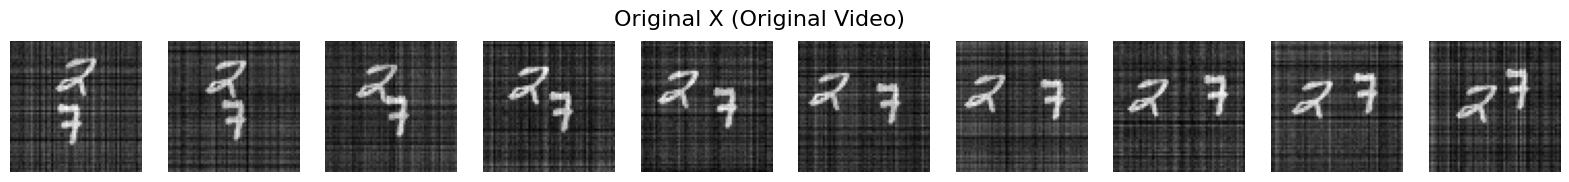

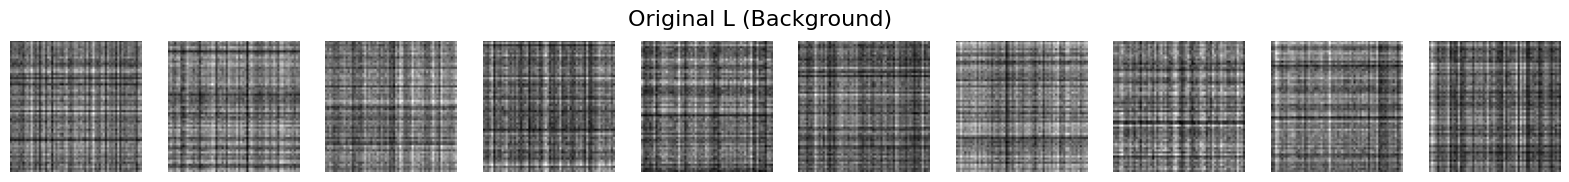

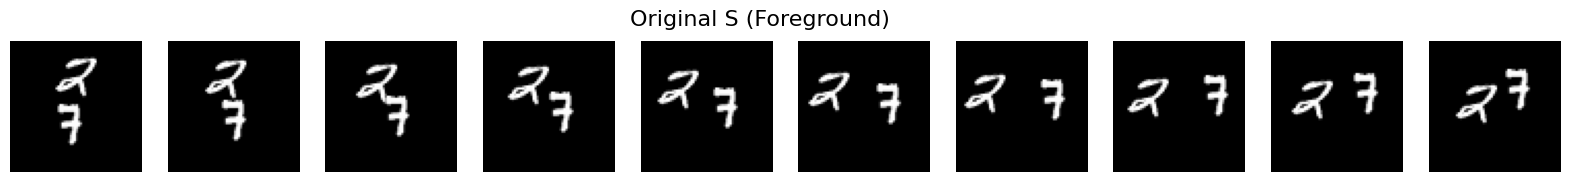



Transformed L_new shape: torch.Size([1, 4096, 10])
Transformed S_new shape: torch.Size([1, 4096, 10])
Transformed X_new shape: torch.Size([1, 4096, 10])


In [81]:
# Display the shape of original data (X)
print("Original X shape:", X.shape)
print("Original L shape:", L.shape)
print("Original S shape:", S.shape)

# Plot the first video frames of original X, L, and S
def plot_video_frames(data, title):
    video_idx = 0  # Selecting the first video (index 0)
    # frames = data[:, video_idx, :, :]  # Shape: (10, 64, 64)

    # If data is 4D, slice the video
    if len(data.shape) == 4:  # Shape: (num_videos, num_frames, height, width)
        frames = data[video_idx]  # Now frames has shape (num_frames, height, width)
    else:
        frames = data  # If data is already in 3D shape

    # Create a figure with 10 subplots (one for each frame)
    num_frames = frames.shape[0]  # Determine the number of frames

    # Create a figure with 10 subplots (one for each frame)
    fig, axs = plt.subplots(1, 10, figsize=(20, 2))
    fig.suptitle(title, fontsize=16)

    for i in range(10):
        axs[i].imshow(frames[i], cmap='gray')
        axs[i].axis('off')

    plt.show()

# Plot original X, L, and S
print("\nPlots for Original")
plot_video_frames(X, "Original X (Original Video)")
plot_video_frames(L, "Original L (Background)")
plot_video_frames(S, "Original S (Foreground)")

# Simulating transformation via the dataset
# L_new, S_new, X_new represent transformed data after the dataloader
L_new, S_new, X_new = dataset[0]  # Dataset returns transformed tensors

# Display the shape of transformed data (L_new, S_new, X_new)
print("\n")
print("Transformed L_new shape:", L_new.shape)
print("Transformed S_new shape:", S_new.shape)
print("Transformed X_new shape:", X_new.shape)


Now design a neural network with up to 5 layers based on the intuition for low rank and sparse solutions developed above. Each layer should contain two branches for performing proximal operations for the low rank and sparse component respectively.

During training, plot the following:
1. MSE Loss as a function of the number of epochs.
2. Final values of learnt thresholding parameters for the L and S brances as a function of layer number.

For the test data, plot the following two charts by averaging over all points:
1. Low Rank:
  - 3D plot showing layer number and index of singular value on the x and y axes and the singular values themselves on the z axis.

2. Sparse:
  - 2D plot showing layer number on the x axis and number of sparse values on the y axis.

In [115]:
class ISTABlock(nn.Module):
    def __init__(self, branch, kernel_size=3):
        """Initialize the ISTA block with a convolution layer and a learnable threshold."""
        super(ISTABlock, self).__init__()
        self.branch = branch
        self.conv = nn.Conv2d(1, 1, kernel_size=kernel_size, padding=1)
        self.threshold = nn.Parameter(torch.tensor(0.1))  # Learnable threshold parameter

    def _soft(self, X, thr):
        """Apply soft-thresholding to the input tensor."""
        return torch.sign(X) * F.relu(torch.abs(X) - thr)

    def _svt(self, X, thr):
        """
        Apply Singular Value Thresholding (SVT) to the input tensor.
        The input tensor X is expected to be a batch of matrices (3D tensor).
        """
        batch_size = X.size(0)
        U_list, S_list, V_list = [], [], []

        # Apply SVD for each sample in the batch
        for i in range(batch_size):
            # Ensure we are applying SVD on a 2D matrix
            U, S, V = torch.svd(X[i].squeeze())  # Remove singleton dimension if necessary
            S_thresholded = F.relu(S - thr)  # Apply the threshold
            U_list.append(U)
            S_list.append(S_thresholded)
            V_list.append(V)

        # Now reconstruct the matrices using the thresholded singular values
        X_svt = []
        for i in range(batch_size):
            X_svt.append(torch.mm(U_list[i], torch.mm(torch.diag(S_list[i]), V_list[i].t())))

        return torch.stack(X_svt).unsqueeze(1)  # Add singleton dimension back if needed



    def forward(self, X):
        """Perform the forward pass through the ISTA block based on the branch type."""
        X = self.conv(X)
        if self.branch == 'L':
            return self._svt(X, self.threshold)
        elif self.branch == 'S':
            return self._soft(X, self.threshold)

class UnfoldedDNN(nn.Module):
    def __init__(self, configs):
        """Initialize the unfolded neural network with ISTA blocks for both 'S' and 'L' branches."""
        super(UnfoldedDNN, self).__init__()
        self.num_layers = configs["num_layers"]  # Extract num_layers from configs
        self.L_blocks = nn.ModuleList([ISTABlock('L') for _ in range(self.num_layers)])
        self.S_blocks = nn.ModuleList([ISTABlock('S') for _ in range(self.num_layers)])

    def get_thresholds(self):
        """Return the thresholds from both branches of the network."""
        return [(L_block.threshold.item(), S_block.threshold.item()) for L_block, S_block in zip(self.L_blocks, self.S_blocks)]

    def forward(self, D):
        """Perform the forward pass through the unfolded neural network and return activations."""
        L, S = D, D
        for L_block, S_block in zip(self.L_blocks, self.S_blocks):
            L = L_block(L)
            S = S_block(S)
        return L, S

Now Train the Model and evaluate the outputs. Complete the plotting functions and feel free to change the configurations or training settings

In [116]:
def plot_mse_loss(epoch_losses):
    """
    Plot MSE loss over epochs.
    """
    plt.figure()
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses)
    plt.title("MSE Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True)
    plt.show()



def plot_threshold_params(L_params, S_params, num_layers):
    """
    Plot threshold parameters for L and S branches across layers.
    Args:
    - L_params: List of lists, each inner list containing L branch thresholds for all layers.
    - S_params: List of lists, each inner list containing S branch thresholds for all layers.
    - num_layers: The number of layers in the model (from the config).
    """
    # Convert lists of thresholds into NumPy arrays for easier averaging
    L_params = np.array(L_params)
    S_params = np.array(S_params)

    # Average the threshold values across epochs for each layer
    avg_L_params_per_layer = np.mean(L_params, axis=0)
    avg_S_params_per_layer = np.mean(S_params, axis=0)

    # Plot the thresholds for each layer
    plt.figure()
    plt.plot(range(1, num_layers + 1), avg_L_params_per_layer, label='L Branch Thresholds', marker='o', color='blue')
    plt.plot(range(1, num_layers + 1), avg_S_params_per_layer, label='S Branch Thresholds', marker='o', color='red')

    plt.title("Threshold Parameters Across Layers")
    plt.xlabel("Layer Number")
    plt.ylabel("Threshold Value")
    plt.legend()
    plt.grid(True)
    plt.show()


def get_singular_values(L_):
    """
    Calculate singular values from the low-rank component.
    Returns singular values for each sample in the batch.
    """
    U, S, V = torch.svd(L_)
    return S.cpu().numpy()  # Return as numpy for easy processing



def get_sparsity(S_, tol=1e-6):
    """
    Calculate sparsity (number of non-zero elements with tolerance 10^-6) from the sparse component.
    Returns sparsity for each sample in the batch.
    """
    # Count the number of non-zero elements in S_ with a small tolerance
    non_zero_elements = (torch.abs(S_) > tol).sum().item()
    total_elements = S_.numel()  # Total number of elements in the tensor
    sparsity = non_zero_elements / total_elements  # Calculate the sparsity as a fraction of non-zero elements

    return sparsity



from mpl_toolkits.mplot3d import Axes3D

def plot_singular_values_over_layers(singular_values_per_layer):
    """
    Plot singular values for each layer as a 3D surface plot.
    Handles multiple layers.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Ensure we have singular values for all layers
    num_layers = len(singular_values_per_layer)

    # Create a mesh grid for plotting
    x = np.arange(len(singular_values_per_layer[0]))  # Singular value indices (number of singular values)
    y = np.arange(num_layers)  # Layer indices (number of layers)
    X, Y = np.meshgrid(x, y)

    # Stack singular values into a 2D array (num_layers x num_singular_values)
    Z = np.array(singular_values_per_layer).squeeze()  # Remove extra dimensions if necessary

    if Z.ndim != 2:
        raise ValueError(f"Expected Z to be 2D, but got {Z.ndim}D. Z shape: {Z.shape}")

    # Plot the surface
    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    ax.set_xlabel('Singular Value Index')
    ax.set_ylabel('Layer Number')
    ax.set_zlabel('Singular Value')
    plt.title("Singular Values Over Layers")
    plt.show()



def plot_sparse_values_over_layers(sparse_values):
    """
    Plot average number of sparse values across layers.
    """
    # Ensure no negative sparsity values
    sparse_values = np.clip(sparse_values, 0, None)  # Clip any negative values to zero

    plt.figure()
    plt.plot(range(1, len(sparse_values) + 1), sparse_values, marker='o', color='red')
    plt.title("Sparse Values Across Layers")
    plt.xlabel("Layer Number")
    plt.ylabel("Average Number of Sparse Values")
    plt.grid(True)
    plt.show()


In [117]:
from tqdm import tqdm

from tqdm import tqdm
import torch

def train(model, train_loader, loss_fn, optimizer, configs):
    model.train()
    epoch_losses = []
    L_params = []  # Store thresholds for L (low-rank) branch
    S_params = []  # Store thresholds for S (sparse) branch

    for epoch in range(configs["epochs"]):
        running_loss = 0.0
        with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{configs['epochs']}]", unit="batch") as pbar:
            for L, S, X in pbar:
                # Move data to device (CPU/GPU)
                L, S, X = L.to(configs["device"]), S.to(configs["device"]), X.to(configs["device"])

                # Zero gradients
                optimizer.zero_grad()

                # Forward pass: Model predicts low-rank (L_) and sparse (S_) components
                L_, S_ = model(X)

                # Compute the loss
                loss = loss_fn(L_, S_, L, S, X)

                # Backpropagation and optimization
                loss.backward()
                optimizer.step()

                # Accumulate loss for the current batch
                running_loss += loss.item() * L.size(0)

                # Display progress
                pbar.set_postfix(loss=running_loss / len(train_loader.dataset))

        # Compute and log epoch loss (average over batches)
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_losses.append(epoch_loss)

        # Get thresholds from model for each layer
        thresholds = model.get_thresholds()
        thresholds_L, thresholds_S = zip(*thresholds)  # Unpack into L and S thresholds

        # Append thresholds per layer
        L_params.append(thresholds_L)
        S_params.append(thresholds_S)

        print(f"Epoch: [{epoch+1}/{configs['epochs']}], Loss: {epoch_loss:.4f}")

    # Plot the MSE loss over epochs and threshold evolution over layers
    plot_mse_loss(epoch_losses)
    plot_threshold_params(L_params, S_params, configs["num_layers"])



def evaluate(model, test_loader, loss_fn, configs):
    model.eval()
    running_loss = 0.0
    all_singular_values = [[] for _ in range(configs["num_layers"])]  # Singular values for each layer
    all_sparsities = [[] for _ in range(configs["num_layers"])]  # Sparsities for each layer

    with torch.no_grad():
        for batch_idx, (L, S, X) in enumerate(test_loader):
            L, S, X = L.to(configs["device"]), S.to(configs["device"]), X.to(configs["device"])

            # Model returns low-rank (L_) and sparse (S_) components
            L_, S_ = model(X)
            loss = loss_fn(L, S, L_, S_, X)
            running_loss += loss.item() * L.size(0)

            # Collect singular values and sparsities for each layer
            for layer_idx in range(configs["num_layers"]):
                # Collect singular values for low-rank component (L_)
                singular_values = get_singular_values(L_[layer_idx])
                if singular_values.ndim == 2:
                    singular_values = singular_values.mean(axis=0)  # Average over batch dimension
                all_singular_values[layer_idx].append(singular_values)

                # Collect sparsities for sparse component (S_)
                sparsity = get_sparsity(S_[layer_idx])  # Assuming S_ has per-layer outputs
                all_sparsities[layer_idx].append(sparsity)

    avg_loss = running_loss / len(test_loader.dataset)
    print(f"Test Loss: {avg_loss:.4f}")

    # Compute the average singular values across the test set for each layer
    avg_singular_values_per_layer = [
        np.mean(layer_singular_values, axis=0) for layer_singular_values in all_singular_values
    ]

    # Compute the average sparsities for each layer, ensuring non-negative values
    avg_sparsities_per_layer = [max(0, np.mean(layer_sparsities)) for layer_sparsities in all_sparsities]  # Clip negative values

    # Plot singular values and sparsities over layers
    plot_singular_values_over_layers(avg_singular_values_per_layer)
    plot_sparse_values_over_layers(avg_sparsities_per_layer)

    return avg_loss


def plot_first_frame(L, S, X):
  L_frame_flat = L[0, 0, :, 0]  # Shape: (4096,)
  S_frame_flat = S[0, 0, :, 0]  # Shape: (4096,)
  X_frame_flat = X[0, 0, :, 0]  # Shape: (4096,)

  L_frame = L_frame_flat.view(64, 64).cpu().numpy()
  S_frame = S_frame_flat.view(64, 64).cpu().numpy()
  X_frame = X_frame_flat.view(64, 64).cpu().numpy()

  fig, axs = plt.subplots(1, 3, figsize=(12, 4))

  axs[0].imshow(L_frame, cmap='gray')
  axs[0].set_title('Background (L)')
  axs[0].axis('off')

  axs[1].imshow(S_frame, cmap='gray')
  axs[1].set_title('Foreground (S)')
  axs[1].axis('off')

  axs[2].imshow(X_frame, cmap='gray')
  axs[2].set_title('Original (D)')
  axs[2].axis('off')

  plt.show()


def loss_fn(L_, S_, L, S, X):
  loss_L = torch.nn.functional.mse_loss(L_, L)
  loss_S = torch.nn.functional.mse_loss(S_, S)
  return loss_L + loss_S

Epoch [1/30]: 100%|██████████| 25/25 [00:06<00:00,  3.86batch/s, loss=0.284]


Epoch: [1/30], Loss: 0.2841


Epoch [2/30]: 100%|██████████| 25/25 [00:05<00:00,  4.56batch/s, loss=0.27]


Epoch: [2/30], Loss: 0.2705


Epoch [3/30]: 100%|██████████| 25/25 [00:07<00:00,  3.33batch/s, loss=0.257]


Epoch: [3/30], Loss: 0.2571


Epoch [4/30]: 100%|██████████| 25/25 [00:05<00:00,  4.57batch/s, loss=0.244]


Epoch: [4/30], Loss: 0.2441


Epoch [5/30]: 100%|██████████| 25/25 [00:05<00:00,  4.26batch/s, loss=0.231]


Epoch: [5/30], Loss: 0.2312


Epoch [6/30]: 100%|██████████| 25/25 [00:05<00:00,  4.27batch/s, loss=0.218]


Epoch: [6/30], Loss: 0.2181


Epoch [7/30]: 100%|██████████| 25/25 [00:05<00:00,  4.62batch/s, loss=0.205]


Epoch: [7/30], Loss: 0.2049


Epoch [8/30]: 100%|██████████| 25/25 [00:06<00:00,  3.99batch/s, loss=0.192]


Epoch: [8/30], Loss: 0.1918


Epoch [9/30]: 100%|██████████| 25/25 [00:05<00:00,  4.66batch/s, loss=0.179]


Epoch: [9/30], Loss: 0.1789


Epoch [10/30]: 100%|██████████| 25/25 [00:06<00:00,  4.00batch/s, loss=0.167]


Epoch: [10/30], Loss: 0.1667


Epoch [11/30]: 100%|██████████| 25/25 [00:05<00:00,  4.58batch/s, loss=0.155]


Epoch: [11/30], Loss: 0.1554


Epoch [12/30]: 100%|██████████| 25/25 [00:05<00:00,  4.41batch/s, loss=0.145]


Epoch: [12/30], Loss: 0.1453


Epoch [13/30]: 100%|██████████| 25/25 [00:06<00:00,  4.12batch/s, loss=0.137]


Epoch: [13/30], Loss: 0.1366


Epoch [14/30]: 100%|██████████| 25/25 [00:05<00:00,  4.60batch/s, loss=0.129]


Epoch: [14/30], Loss: 0.1294


Epoch [15/30]: 100%|██████████| 25/25 [00:06<00:00,  3.97batch/s, loss=0.124]


Epoch: [15/30], Loss: 0.1237


Epoch [16/30]: 100%|██████████| 25/25 [00:05<00:00,  4.64batch/s, loss=0.119]


Epoch: [16/30], Loss: 0.1193


Epoch [17/30]: 100%|██████████| 25/25 [00:08<00:00,  2.87batch/s, loss=0.116]


Epoch: [17/30], Loss: 0.1158


Epoch [18/30]: 100%|██████████| 25/25 [00:05<00:00,  4.57batch/s, loss=0.113]


Epoch: [18/30], Loss: 0.1131


Epoch [19/30]: 100%|██████████| 25/25 [00:05<00:00,  4.27batch/s, loss=0.111]


Epoch: [19/30], Loss: 0.1107


Epoch [20/30]: 100%|██████████| 25/25 [00:05<00:00,  4.34batch/s, loss=0.109]


Epoch: [20/30], Loss: 0.1086


Epoch [21/30]: 100%|██████████| 25/25 [00:05<00:00,  4.62batch/s, loss=0.107]


Epoch: [21/30], Loss: 0.1066


Epoch [22/30]: 100%|██████████| 25/25 [00:06<00:00,  4.03batch/s, loss=0.105]


Epoch: [22/30], Loss: 0.1048


Epoch [23/30]: 100%|██████████| 25/25 [00:05<00:00,  4.60batch/s, loss=0.103]


Epoch: [23/30], Loss: 0.1030


Epoch [24/30]: 100%|██████████| 25/25 [00:06<00:00,  4.06batch/s, loss=0.101]


Epoch: [24/30], Loss: 0.1013


Epoch [25/30]: 100%|██████████| 25/25 [00:05<00:00,  4.60batch/s, loss=0.0996]


Epoch: [25/30], Loss: 0.0996


Epoch [26/30]: 100%|██████████| 25/25 [00:05<00:00,  4.41batch/s, loss=0.0979]


Epoch: [26/30], Loss: 0.0979


Epoch [27/30]: 100%|██████████| 25/25 [00:06<00:00,  4.05batch/s, loss=0.0963]


Epoch: [27/30], Loss: 0.0963


Epoch [28/30]: 100%|██████████| 25/25 [00:05<00:00,  4.60batch/s, loss=0.0947]


Epoch: [28/30], Loss: 0.0947


Epoch [29/30]: 100%|██████████| 25/25 [00:06<00:00,  4.00batch/s, loss=0.093]


Epoch: [29/30], Loss: 0.0930


Epoch [30/30]: 100%|██████████| 25/25 [00:05<00:00,  4.58batch/s, loss=0.0914]


Epoch: [30/30], Loss: 0.0914


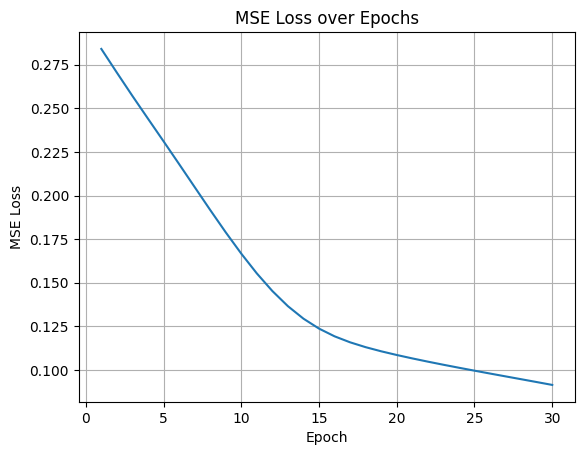

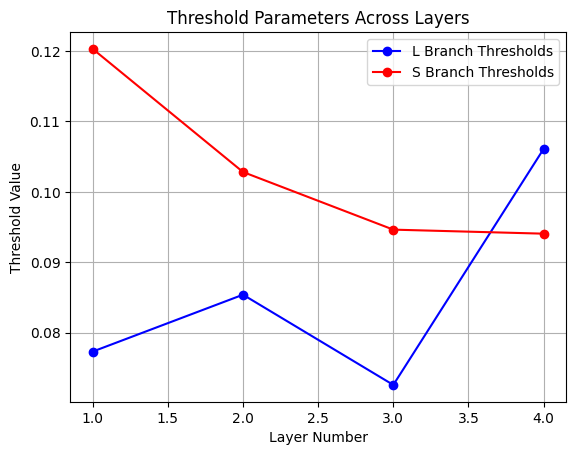

In [118]:
# Model and training configurations
configs = {
    "num_layers": 4,
    "kernel_size": 3,
    "lr": 1e-4,
    "epochs": 30,
    "batch_size": 32,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# Initialize the model, optimizer, and datasets
model = UnfoldedDNN(configs).to(configs["device"])
optimizer = Adam(model.parameters(), lr=configs["lr"])

# Train the model
train(model, train_loader, loss_fn, optimizer, configs)

Test Loss: 0.0908


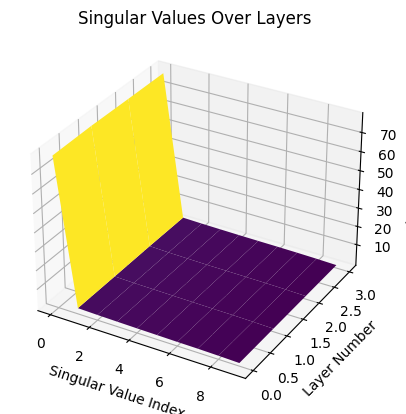

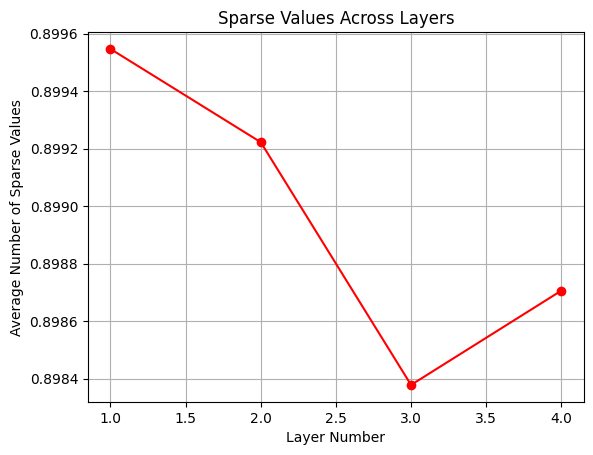

0.0907989799976349

In [119]:
# Evaluate the model
evaluate(model, test_loader, loss_fn, configs)

# Task 5: RPCA with Mixed Norms

Add your solution to this task from the manual in the cells below.

In [120]:
class ISTABlock(nn.Module):
    def __init__(self, branch, kernel_size=3):
        """Initialize the ISTA block with a convolution layer and a learnable threshold."""
        super(ISTABlock, self).__init__()
        self.branch = branch
        self.conv = nn.Conv2d(1, 1, kernel_size=kernel_size, padding=1)
        self.threshold = nn.Parameter(torch.tensor(0.1))  # Learnable threshold parameter

    def _soft(self, X, thr):
        """Apply soft-thresholding to the input tensor."""
        return torch.sign(X) * F.relu(torch.abs(X) - thr)

    def _svt(self, X, thr):
        """
        Apply Singular Value Thresholding (SVT) to the input tensor.
        The input tensor X is expected to be a batch of matrices (3D tensor).
        """
        batch_size = X.size(0)
        U_list, S_list, V_list = [], [], []

        # Apply SVD for each sample in the batch
        for i in range(batch_size):
            # Ensure we are applying SVD on a 2D matrix
            U, S, V = torch.svd(X[i].squeeze())  # Remove singleton dimension if necessary
            S_thresholded = F.relu(S - thr)  # Apply the threshold
            U_list.append(U)
            S_list.append(S_thresholded)
            V_list.append(V)

        # Now reconstruct the matrices using the thresholded singular values
        X_svt = []
        for i in range(batch_size):
            X_svt.append(torch.mm(U_list[i], torch.mm(torch.diag(S_list[i]), V_list[i].t())))

        return torch.stack(X_svt).unsqueeze(1)  # Add singleton dimension back if needed

    def _l1_2_prox(self, X, thr):
      """Apply the proximal operator for the L1,2 norm to the input tensor."""
      # Reshape X to have the rows (grouping along the last dimension)
      # Assuming the L2 norm is applied across the last dimension
      norms = torch.norm(X, dim=-1, keepdim=True)  # Compute L2 norm of each row
      scale = torch.maximum(norms - thr, torch.zeros_like(norms)) / norms  # Soft-threshold the norms
      scale[norms == 0] = 0  # Avoid division by zero
      return X * scale  # Scale rows of X by the thresholded norms

    def forward(self, X):
        """Perform the forward pass through the ISTA block based on the branch type."""
        X = self.conv(X)
        if self.branch == 'L':
            return self._svt(X, self.threshold)
        elif self.branch == 'S':
            return self._l1_2_prox(X, self.threshold)

class UnfoldedDNN(nn.Module):
    def __init__(self, configs):
        """Initialize the unfolded neural network with ISTA blocks for both 'S' and 'L' branches."""
        super(UnfoldedDNN, self).__init__()
        self.num_layers = configs["num_layers"]  # Extract num_layers from configs
        self.L_blocks = nn.ModuleList([ISTABlock('L') for _ in range(self.num_layers)])
        self.S_blocks = nn.ModuleList([ISTABlock('S') for _ in range(self.num_layers)])

    def get_thresholds(self):
        """Return the thresholds from both branches of the network."""
        return [(L_block.threshold.item(), S_block.threshold.item()) for L_block, S_block in zip(self.L_blocks, self.S_blocks)]

    def forward(self, D):
        """Perform the forward pass through the unfolded neural network and return activations."""
        L, S = D, D
        for L_block, S_block in zip(self.L_blocks, self.S_blocks):
            L = L_block(L)
            S = S_block(S)
        return L, S

Epoch [1/30]: 100%|██████████| 25/25 [00:06<00:00,  3.86batch/s, loss=0.705]


Epoch: [1/30], Loss: 0.7048


Epoch [2/30]: 100%|██████████| 25/25 [00:05<00:00,  4.54batch/s, loss=0.677]


Epoch: [2/30], Loss: 0.6771


Epoch [3/30]: 100%|██████████| 25/25 [00:06<00:00,  4.10batch/s, loss=0.652]


Epoch: [3/30], Loss: 0.6520


Epoch [4/30]: 100%|██████████| 25/25 [00:05<00:00,  4.35batch/s, loss=0.629]


Epoch: [4/30], Loss: 0.6293


Epoch [5/30]: 100%|██████████| 25/25 [00:05<00:00,  4.47batch/s, loss=0.609]


Epoch: [5/30], Loss: 0.6086


Epoch [6/30]: 100%|██████████| 25/25 [00:06<00:00,  3.98batch/s, loss=0.59]


Epoch: [6/30], Loss: 0.5899


Epoch [7/30]: 100%|██████████| 25/25 [00:05<00:00,  4.57batch/s, loss=0.573]


Epoch: [7/30], Loss: 0.5729


Epoch [8/30]: 100%|██████████| 25/25 [00:06<00:00,  3.96batch/s, loss=0.557]


Epoch: [8/30], Loss: 0.5575


Epoch [9/30]: 100%|██████████| 25/25 [00:05<00:00,  4.56batch/s, loss=0.543]


Epoch: [9/30], Loss: 0.5434


Epoch [10/30]: 100%|██████████| 25/25 [00:05<00:00,  4.29batch/s, loss=0.531]


Epoch: [10/30], Loss: 0.5308


Epoch [11/30]: 100%|██████████| 25/25 [00:05<00:00,  4.23batch/s, loss=0.519]


Epoch: [11/30], Loss: 0.5190


Epoch [12/30]: 100%|██████████| 25/25 [00:05<00:00,  4.60batch/s, loss=0.508]


Epoch: [12/30], Loss: 0.5080


Epoch [13/30]: 100%|██████████| 25/25 [00:06<00:00,  3.99batch/s, loss=0.498]


Epoch: [13/30], Loss: 0.4975


Epoch [14/30]: 100%|██████████| 25/25 [00:05<00:00,  4.57batch/s, loss=0.488]


Epoch: [14/30], Loss: 0.4875


Epoch [15/30]: 100%|██████████| 25/25 [00:06<00:00,  4.04batch/s, loss=0.478]


Epoch: [15/30], Loss: 0.4779


Epoch [16/30]: 100%|██████████| 25/25 [00:05<00:00,  4.54batch/s, loss=0.469]


Epoch: [16/30], Loss: 0.4686


Epoch [17/30]: 100%|██████████| 25/25 [00:05<00:00,  4.52batch/s, loss=0.459]


Epoch: [17/30], Loss: 0.4594


Epoch [18/30]: 100%|██████████| 25/25 [00:06<00:00,  4.11batch/s, loss=0.45]


Epoch: [18/30], Loss: 0.4505


Epoch [19/30]: 100%|██████████| 25/25 [00:05<00:00,  4.58batch/s, loss=0.442]


Epoch: [19/30], Loss: 0.4416


Epoch [20/30]: 100%|██████████| 25/25 [00:06<00:00,  3.90batch/s, loss=0.433]


Epoch: [20/30], Loss: 0.4329


Epoch [21/30]: 100%|██████████| 25/25 [00:05<00:00,  4.58batch/s, loss=0.424]


Epoch: [21/30], Loss: 0.4243


Epoch [22/30]: 100%|██████████| 25/25 [00:05<00:00,  4.19batch/s, loss=0.416]


Epoch: [22/30], Loss: 0.4159


Epoch [23/30]: 100%|██████████| 25/25 [00:05<00:00,  4.20batch/s, loss=0.408]


Epoch: [23/30], Loss: 0.4075


Epoch [24/30]: 100%|██████████| 25/25 [00:05<00:00,  4.58batch/s, loss=0.399]


Epoch: [24/30], Loss: 0.3994


Epoch [25/30]: 100%|██████████| 25/25 [00:06<00:00,  3.98batch/s, loss=0.391]


Epoch: [25/30], Loss: 0.3913


Epoch [26/30]: 100%|██████████| 25/25 [00:05<00:00,  4.62batch/s, loss=0.383]


Epoch: [26/30], Loss: 0.3834


Epoch [27/30]: 100%|██████████| 25/25 [00:06<00:00,  4.00batch/s, loss=0.376]


Epoch: [27/30], Loss: 0.3757


Epoch [28/30]: 100%|██████████| 25/25 [00:05<00:00,  4.60batch/s, loss=0.368]


Epoch: [28/30], Loss: 0.3681


Epoch [29/30]: 100%|██████████| 25/25 [00:05<00:00,  4.37batch/s, loss=0.361]


Epoch: [29/30], Loss: 0.3605


Epoch [30/30]: 100%|██████████| 25/25 [00:06<00:00,  4.15batch/s, loss=0.353]


Epoch: [30/30], Loss: 0.3531


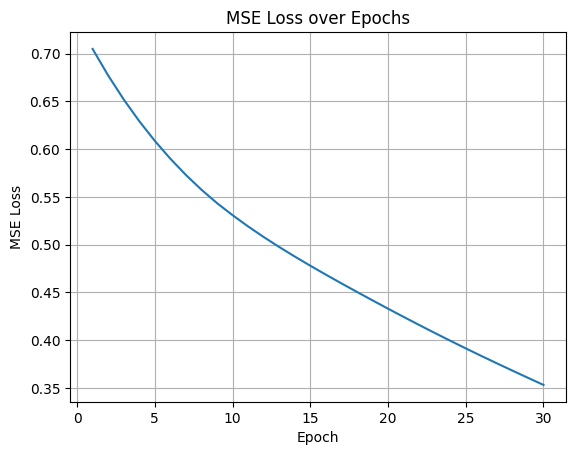

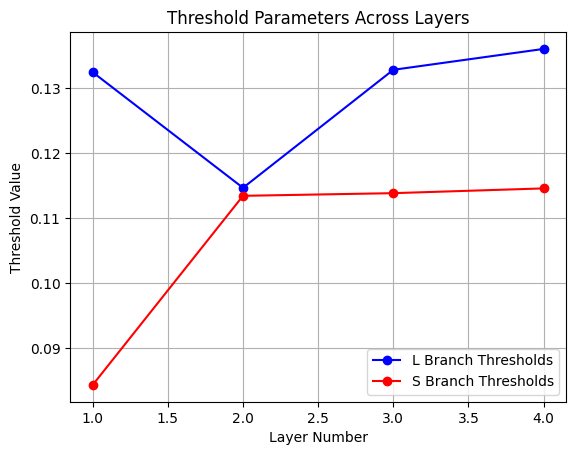

In [121]:
# Model and training configurations
configs = {
    "num_layers": 4,
    "kernel_size": 3,
    "lr": 1e-4,
    "epochs": 30,
    "batch_size": 32,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# Initialize the model, optimizer, and datasets
model = UnfoldedDNN(configs).to(configs["device"])
optimizer = Adam(model.parameters(), lr=configs["lr"])

# Train the model
train(model, train_loader, loss_fn, optimizer, configs)

Test Loss: 0.3516


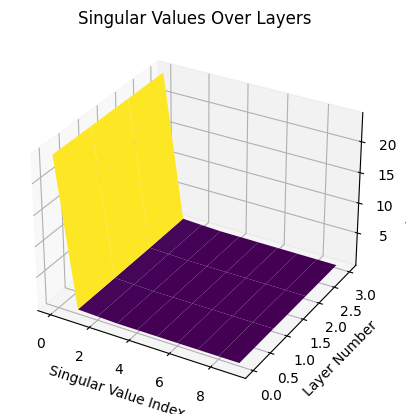

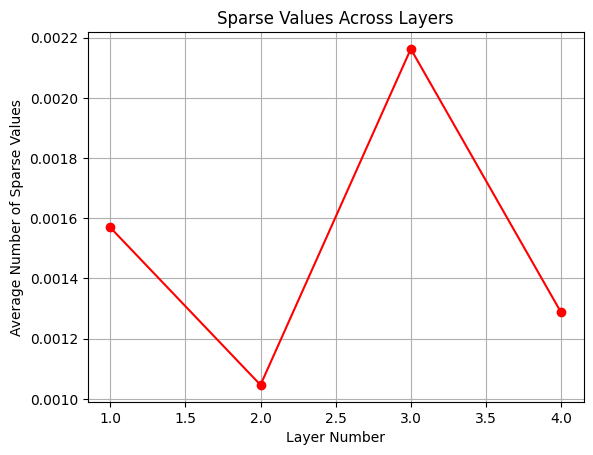

0.35156732201576235

In [122]:
# Evaluate the model
evaluate(model, test_loader, loss_fn, configs)